This notebook contains all the code necessary to reproduce the plots in my dissertation. All work is my own unless otherwise stated. 

Author: Oliver Kemp, 2023

### IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf
import pandas as pd
import datetime 
import itertools
import cobyqa
from tqdm import tqdm
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter
from py_vollib_vectorized.implied_volatility import vectorized_implied_volatility as implied_vol
from scipy.integrate import quad, odeint
from scipy.optimize import minimize
from multiprocess import Pool
from IPython.display import clear_output


sns.set(context='notebook', style='whitegrid')
plt.rcParams['text.usetex'] = True
DPI = 400

tdy = datetime.datetime.today()


# Define the colors for the colormap
colors = ["blue", "red"]

# Create the colormap object
cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

# Set the default color cycle to the colormap
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cmap(np.linspace(0, 1, 4)))

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Vanilla option payoffs

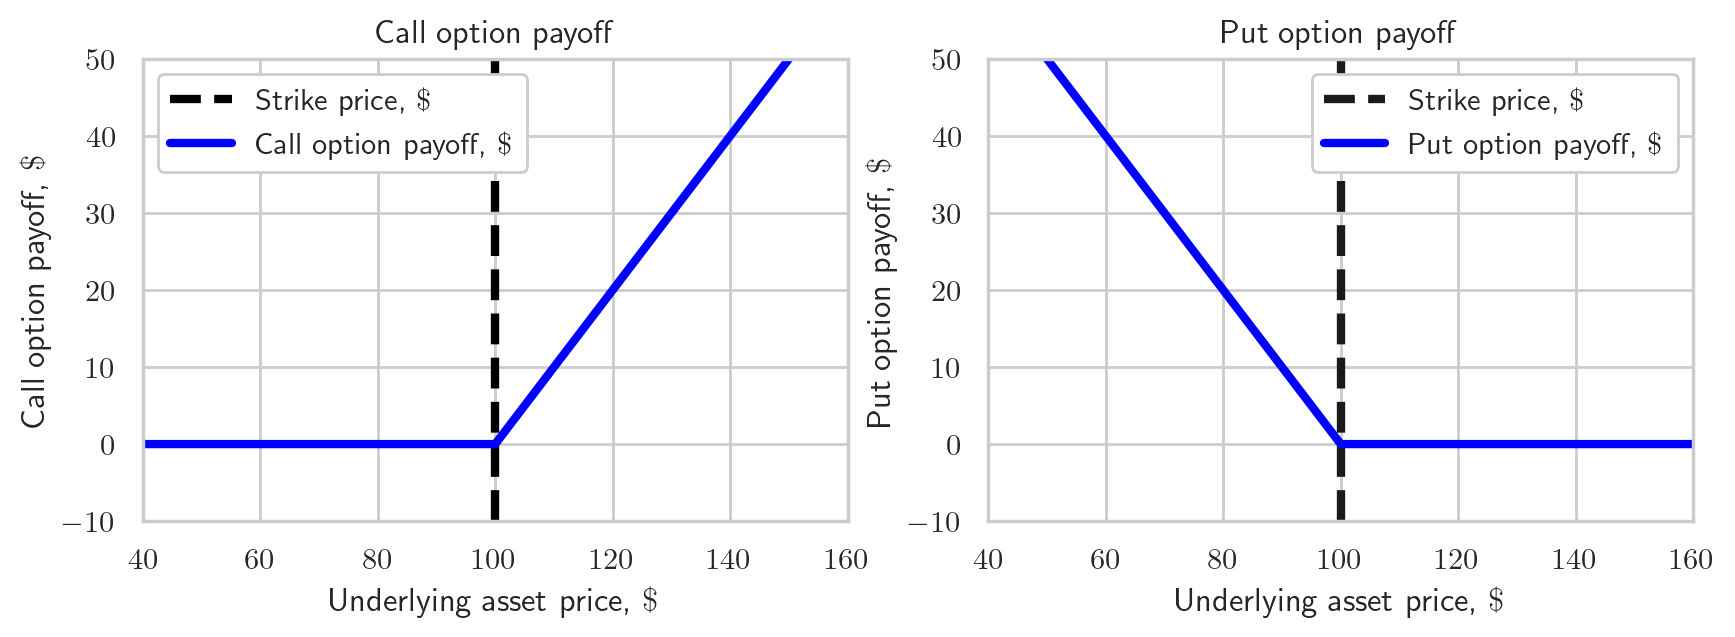

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=200)

# Calculate call option payoff
K = 100
S = np.linspace(40, 160, 1000)
call_payoff = np.maximum(S - K, 0)

# Calculate put option payoff
put_payoff = np.maximum(K - S, 0)
axs[0].vlines(K, -10, 50, linestyle = '--',linewidth=3, label = r'Strike price, $\$$', colors='black')
axs[0].plot(S, call_payoff, label=r'Call option payoff, $\$$', linewidth=3,color='blue')
axs[0].set_ylim(-10, 50)
axs[0].set_xlim(40, 160)
axs[0].set_title('Call option payoff')
axs[0].set_xlabel(r'Underlying asset price, $\$$')
axs[0].set_ylabel(r'Call option payoff, $\$$')
leg = axs[0].legend(loc='upper left', framealpha=1)



# Plot put option payoff

axs[1].vlines(K, -10, 50, linestyle = '--',linewidth=3, label = r'Strike price, $\$$', colors='k')
axs[1].plot(S, put_payoff, label=r'Put option payoff, $\$$', linewidth=3,color='blue')
axs[1].set_ylim(-10, 50)
axs[1].set_xlim(40, 160)
axs[1].set_title('Put option payoff')
axs[1].set_xlabel(r'Underlying asset price, $\$$')
axs[1].set_ylabel(r'Put option payoff, $\$$')
leg = axs[1].legend(loc='upper right', framealpha=1)


plt.savefig('call_put_payoff.png', dpi=DPI, bbox_inches='tight')

### Volatility smile and surface

In [3]:
def option_chain(ticker):
    """
    Fetches the option chain for the specified ticker symbol.
    Thanks to https://medium.com/@txlian13/webscrapping-options-data-with-python-and-yfinance-e4deb0124613
    
    Args:
        ticker (str): Ticker symbol of the asset.
        
    Returns:
        pandas.DataFrame: Option chain data including calls and puts.
    """
    # Create a Ticker object for the asset
    asset = yf.Ticker(ticker)
    
    # Get the expiration dates for the options
    expirations = asset.options
    
    # Create an empty DataFrame to store the option chain
    chains = pd.DataFrame()
    
    # Iterate over each expiration date
    for expiration in expirations:
        # Fetch the option chain for the current expiration date
        opt = asset.option_chain(expiration)
        
        # Separate calls and puts
        calls = opt.calls
        calls['optionType'] = "call"  # Add a new column to indicate option type
        
        puts = opt.puts
        puts['optionType'] = "put"  # Add a new column to indicate option type
        
        # Concatenate calls and puts into a single DataFrame
        chain = pd.concat([calls, puts])
        
        # Set the expiration column to the current expiration date
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        
        # Concatenate the current chain with the previous chains
        chains = pd.concat([chains, chain])
    
    # Calculate the number of days to expiration for each option
    chains["daysToExpiration"] = (chains.expiration - datetime.datetime.today()).dt.days + 1
    
    return chains

In [4]:
# UNCOMMENT IF NOT USING option_data.csv
#chain = option_chain('AAPL')
chain = pd.read_csv('option_data.csv')
smile = chain[np.logical_and(chain.daysToExpiration == 9, chain.optionType == 'call')]
current_price=174

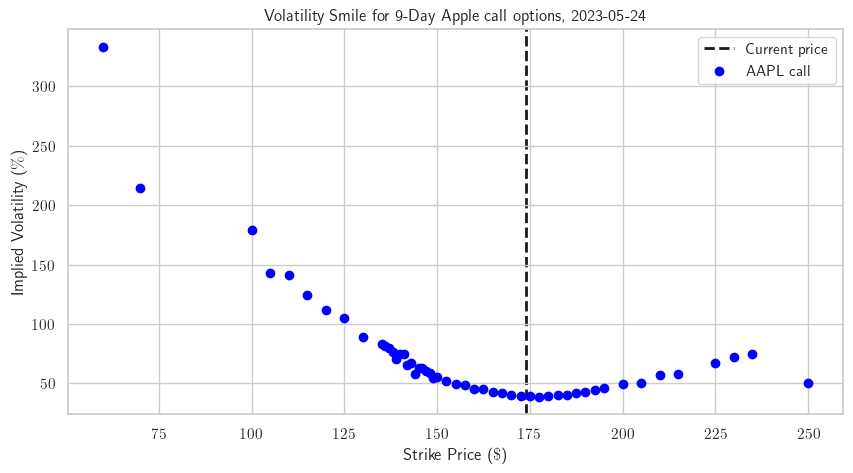

In [5]:
# Get strikes and implied volatilities
strikes = smile['strike']
implied_volatilities = smile['impliedVolatility'] * 100

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.axvline(x=current_price, linestyle='--', color='k', linewidth=2, label='Current price', zorder=0)
s = ax.scatter(strikes, implied_volatilities, label = 'AAPL call', c='blue')#, c=smile.lastPrice, cmap='cool')
ax.set_title(f'Volatility Smile for 9-Day Apple call options, {tdy.date()}')
ax.set_xlabel('Strike Price ($\$$)')
ax.set_ylabel('Implied Volatility ($\\%$)')
ax.grid(True)



ax.legend()
plt.savefig('AAPL_smile.png', dpi=DPI, bbox_inches='tight')

plt.show()

### Volatility surface

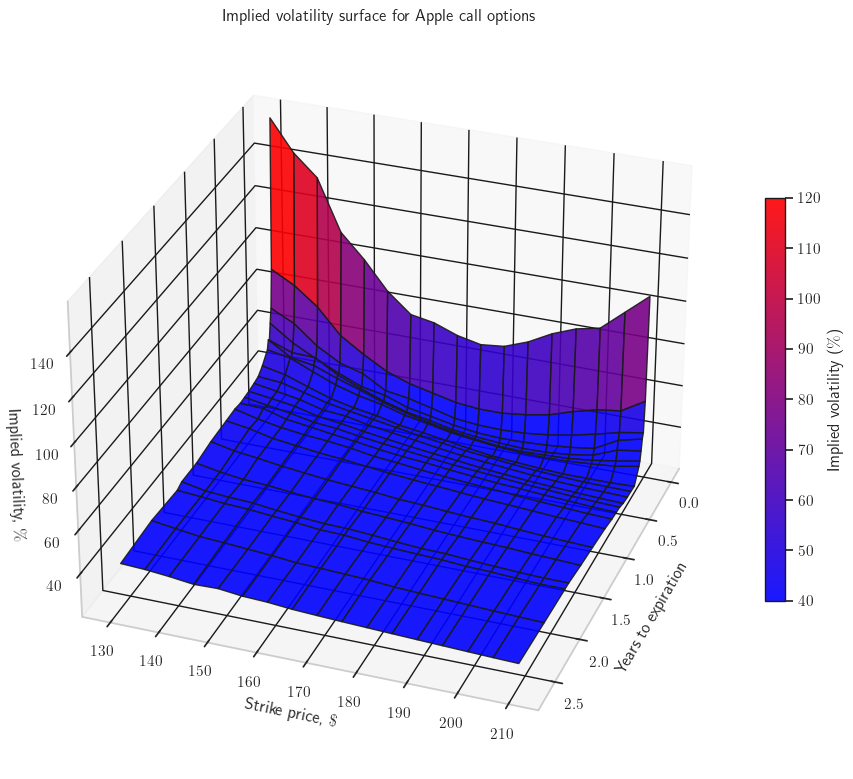

In [6]:
# Filter the 'chain' dataframe to only include rows where 'optionType' is 'call'
calls = chain[chain.optionType == 'call']

# Select specific columns from the 'calls' dataframe, pivot the table using 'strike' as index and 'daysToExpiration' as columns, and remove any rows with missing values (NaN)
surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# Define a list of colors
colors = ["blue", "red"]

# Define the name of the colormap
cmap_name = "my_cmap"

# Create a list of tuples to specify the colors in the colormap
# The first element in each tuple is the position along the colormap, and the second is the color
colors_list = [(0, colors[0]), (1, colors[1])]

# Create the colormap object
cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors_list)

# Compute the minimum implied volatility and multiply by 100
vmin = calls.impliedVolatility.min() * 100

# Compute the maximum implied volatility and multiply by 100
vmax = calls.impliedVolatility.max() * 100

# Create a figure object with a size of 10x10 inches and a resolution of 100 dots per inch
fig = plt.figure(figsize=(10, 10), dpi=100)

# Add a 3D subplot to the figure
ax = fig.add_subplot(projection='3d')

# Extract the values for x, y, and z from the 'surface' dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values

# Divide x values by 365 to represent years to expiration
x = x / 365

# Create coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

# Plot the surface using the coordinate matrices and specified parameters
s = ax.plot_surface(X, Y, z * 100, cmap=cmap, vmin=40, vmax=120, alpha=0.9, edgecolor='k', rstride=1, cstride=1)

# Set the color of x-axis grid lines to black
ax.xaxis._axinfo["grid"]['color'] = 'k'

# Set the color of y-axis grid lines to black
ax.yaxis._axinfo["grid"]['color'] = 'k'

# Set the color of z-axis grid lines to black
ax.zaxis._axinfo["grid"]['color'] = 'k'

# Set the view angle for the plot
ax.view_init(30, 20)

# Set the label for the x-axis
ax.set_xlabel('Years to expiration')

# Set the label for the y-axis with LaTeX formatting
ax.set_ylabel(r'Strike price, $\$$')

# Set the label for the z-axis with LaTeX formatting
ax.set_zlabel(r'Implied volatility, $\%$')

# Add a colorbar to the plot with specified label and position
cb = plt.colorbar(s, label=r'Implied volatility ($\%$)', fraction=0.026, pad=0.02)

# Set the color of the colorbar outline to black
cb.outline.set_color('k')

# Set the linewidth of the colorbar outline to 1
cb.outline.set_linewidth(1)

# Set the title of the plot
plt.title('Implied volatility surface for Apple call options')

# Save the plot
plt.savefig('AAPL_vol_surface.png', dpi=DPI, bbox_inches='tight')
plt.show()

### S&P 500 data

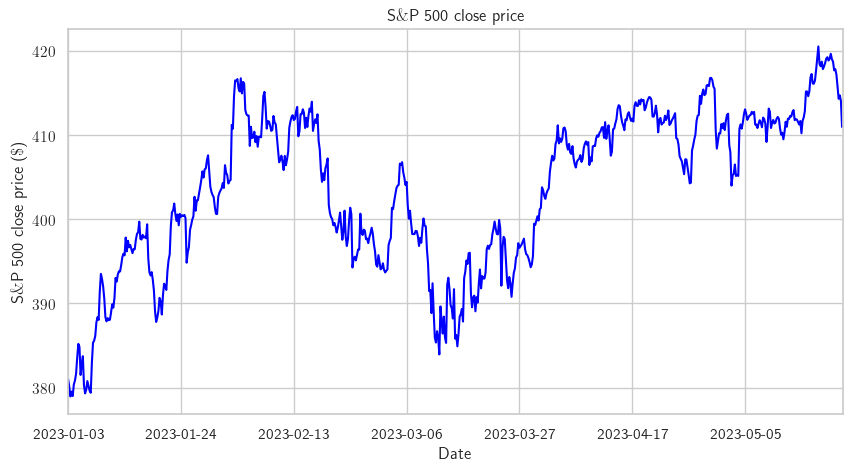

In [7]:
# Retrieve data for the 'SPY' ticker
tick = yf.Ticker('SPY')

# Get historical data for the specified date range and interval
hist = tick.history(start='2023-01-01', end=tdy, interval='1h')

# Create a figure and axis objects for plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the closing prices
ax.plot(np.arange(hist.Close.shape[0]), hist.Close, color='blue')

# Set the x-label
ax.set_xlabel('Date')

# Set the y-label
ax.set_ylabel('S$\&$P 500 close price ($\\$$)')

# Set the title of the plot
ax.set_title('S$\&$P 500 close price ')

# Set the x-axis tick positions and labels
ax.set_xticks(np.arange(hist.Close.shape[0])[::100], hist.index.date[::100])

# Set the x-axis limits
ax.set_xlim(0, hist.Close.shape[0])

# Save the plot as an image file
plt.savefig('SP500.png', dpi=DPI, bbox_inches='tight')

# Display the plot
plt.show()

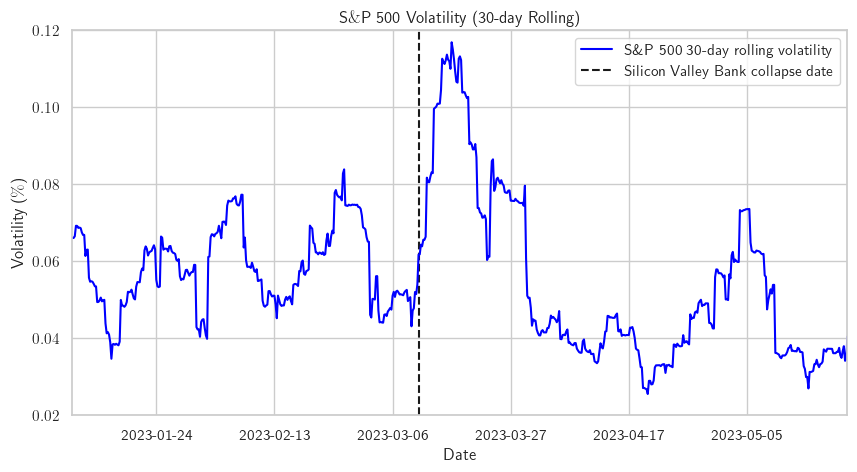

In [8]:
# Calculate the percentage returns based on the closing prices
returns = np.diff(hist['Close']) / hist['Close'][:-1]

# Calculate rolling volatility over a 30-day window
rolling_volatility = returns.rolling(window=30).std() * np.sqrt(252)

# Get the dates from the rolling volatility index
dates = rolling_volatility.index.date

# Create an index array
index = np.arange(len(dates))

# Create a figure and axis objects for plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the rolling volatility
ax.plot(index, rolling_volatility, color='blue', label='S\\&P 500 30-day rolling volatility')

# Set the x-label
ax.set_xlabel('Date')

# Set the y-label
ax.set_ylabel('Volatility ($\\%$)')

# Set the title of the plot
ax.set_title('S$\&$P 500 Volatility (30-day Rolling)')

# Add a vertical line for the collapse date of Silicon Valley Bank
ax.axvline(x=index[dates == datetime.date(2023, 3, 10)][0], color='k', linestyle='--', zorder=0, label='Silicon Valley Bank collapse date')

# Set the x-axis tick positions and labels
ax.set_xticks(index[::100], dates[::100])

# Set the x-axis limits based on the valid rolling volatility data
ax.set_xlim(np.min(index[~np.isnan(rolling_volatility)]), np.max(index[~np.isnan(rolling_volatility)]))

# Set the y-axis limits
ax.set_ylim(0.02, 0.12)

# Plot the legend
plt.legend()

# Save the plot as an image file
plt.savefig('SP500_vol.png', dpi=DPI, bbox_inches='tight')

# Display the plot
plt.show()


### Black-Scholes greeks

In [9]:
class BlackScholesPricer:
    """
    A class that implements the Black-Scholes option pricing model and provides methods to calculate option prices
    and Greeks.

    Attributes:
        S (float): Underlying asset price.
        K (float): Strike price.
        t (float): Time to expiration in years.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        call_flag (bool): Indicates whether the option is a call option (True) or a put option (False).
        d1 (float): The d1 parameter used in the Black-Scholes formula.
        d2 (float): The d2 parameter used in the Black-Scholes formula.
        option_price (float): The calculated option price using the Black-Scholes formula.

    Methods:
        black_scholes(): Calculates the option price using the Black-Scholes formula.
        delta(): Calculates the delta of the option.
        vega(): Calculates the vega of the option.
        theta(): Calculates the theta of the option.
        gamma(): Calculates the gamma of the option.
        vanna(): Calculates the vanna of the option.
        volga(): Calculates the volga of the option.
    """

    def __init__(self, S, K, t, r, sigma, call_flag=True):
        """
        Initializes the BlackScholesPricer object with the provided parameters.

        Args:
            S (float): Underlying asset price.
            K (float): Strike price.
            t (float): Time to expiration in years.
            r (float): Risk-free interest rate.
            sigma (float): Volatility of the underlying asset.
            call_flag (bool): Indicates whether the option is a call option (True) or a put option (False).
        """
        self.S = S
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma 
        self.call_flag = call_flag
        self.black_scholes()

    def black_scholes(self):
        """
        Calculates the option price using the Black-Scholes formula.

        Returns:
            float: The calculated option price.
        """
        self.d1 = (1/(self.sigma*((self.t)**0.5))) * (np.log(self.S/self.K) + (self.r + (self.sigma**2)/2) * (self.t))
        self.d2 = self.d1 - self.sigma * ((self.t) ** 0.5)
        if self.call_flag:
            self.option_price = norm.cdf(self.d1) * self.S - norm.cdf(self.d2) * self.K * np.exp(-self.r*(self.t))
        else:
            self.option_price = self.K * np.exp(-self.r*(self.t)) * norm.cdf(-self.d2) - self.S * norm.cdf(-self.d1)
        return self.option_price
    
    def delta(self):
        """
        Calculates the delta of the option.

        Returns:
            float: The delta of the option.
        """
        return norm.cdf(self.d1)
    
    def vega(self):
        """
        Calculates the vega of the option.

        Returns:
            float: The vega of the option.
        """
        return self.S * norm.pdf(self.d1) * np.sqrt(self.t)

    def theta(self):
        """
        Calculates the theta of the option.

        Returns:
            float: The theta of the option.
        """
        x = -(self.S*norm.pdf(self.d1)*self.sigma)/(2*np.sqrt(self.t))
        y = self.r*self.K*np.exp(-self.r*(self.t))*norm.cdf(self.d2)
        return x - y
    
    def gamma(self):
        """
        Calculates the gamma of the option.

        Returns:
            float: The gamma of the option.
        """
        return norm.pdf(self.d1) / (self.sigma * self.S * np.sqrt(self.t))
    
    def vanna(self):
        """
        Calculates the vanna of the option.

        Returns:
            float: The vanna of the option.
        """
        x = self.d1 ** 2 / (self.sigma * np.sqrt(self.t))
        return (self.vega() / self.S) * (1 - x)
    
    def volga(self):
        """
        Calculates the volga of the option.

        Returns:
            float: The volga of the option.
        """
        return self.vega() * ((self.d1 * self.d2) / self.sigma)


/var/folders/cn/6w6_5cbx5wq5y54qfcv60t7m0000gn/T/ipykernel_97871/3093541761.py:54: RuntimeWarning: divide by zero encountered in log
  self.d1 = (1/(self.sigma*((self.t)**0.5))) * (np.log(self.S/self.K) + (self.r + (self.sigma**2)/2) * (self.t))
/var/folders/cn/6w6_5cbx5wq5y54qfcv60t7m0000gn/T/ipykernel_97871/3093541761.py:98: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(self.d1) / (self.sigma * self.S * np.sqrt(self.t))


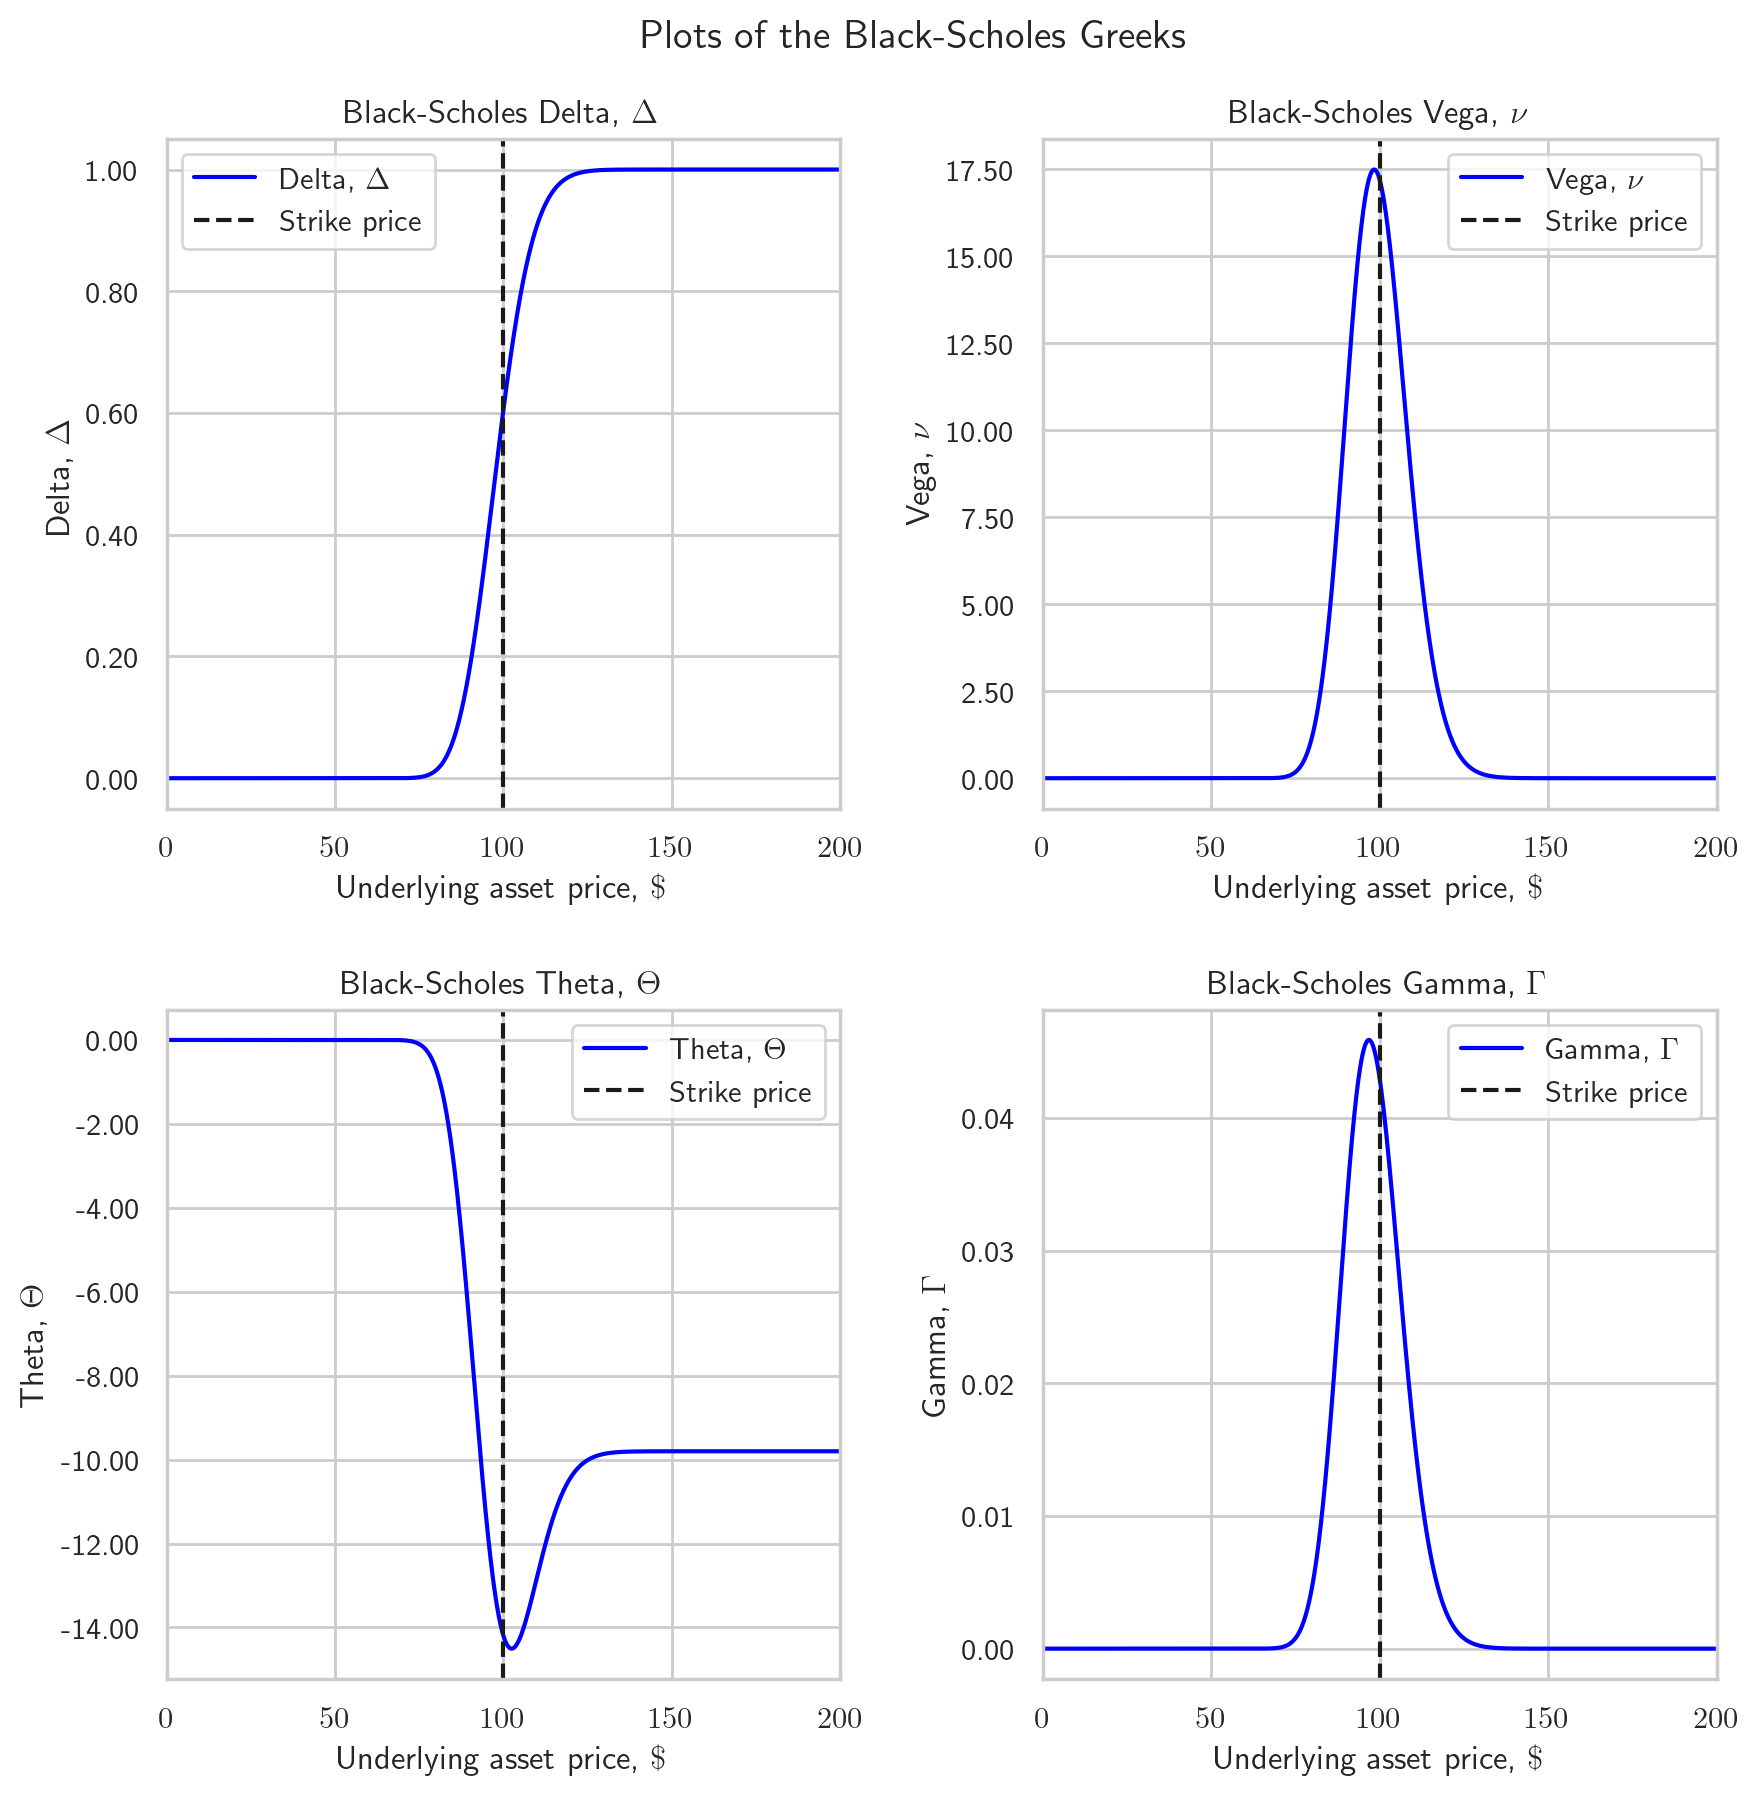

In [10]:
# Define the parameters for the Black-Scholes model
black_scholes_params = {
    'S':np.linspace(0, 200, 10000),  # An array of stock prices ranging from 0 to 200 with 10,000 points
    'K':100,  # The strike price of the option
    't':0.2,  # The time to expiration in years
    'r':0.1,  # The risk-free interest rate
    'sigma':0.2,  # The volatility of the underlying asset
    'call_flag':True  # A boolean value indicating whether the option is a call option (True) or a put option (False)
}

# Instantiate the BlackScholesPricer class with the parameters in the dictionary
bspricer = BlackScholesPricer(**black_scholes_params)

# Compute the Greeks using the BlackScholesPricer class methods
greeks = np.array([
    [bspricer.delta(), bspricer.vega()],  # Delta and Vega
    [bspricer.theta(), bspricer.gamma()]  # Theta and Gamma
])

# Define the names for the Greeks for use in plot titles and y-axis labels
names = np.array([
    [r'Delta, $\Delta$', r'Vega, $\nu$'],  # Delta and Vega names
    [r'Theta, $\Theta$', r'Gamma, $\Gamma$']  # Theta and Gamma names
])

# Create a 2x2 subplot of the four Greeks
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Iterate over each subplot and plot the Greek values against the underlying asset price (S)
for i, j in itertools.product(range(2), range(2)):
    axs[i, j].plot(bspricer.S, greeks[i, j], color='blue', label = names[i, j])  # Plot the Greek values against the underlying asset price (S)
    axs[i, j].axvline(bspricer.K, color='k', linestyle='--', label='Strike price')  # Add a red dashed line for the strike price (K)
    axs[i, j].set_title('Black-Scholes ' + names[i, j])  # Set the plot title
    axs[i, j].set_xlim(0, 200)  # Set the x-axis limits
    axs[i, j].set_xlabel('Underlying asset price, $\\$$')  # Set the x-axis label
    axs[i, j].set_ylabel(names[i, j])  # Set the y-axis label
    axs[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Set the y-axis format to two decimal places
    axs[i, j].legend()  # Add a legend to the plot

# Set the overall plot title and save the plot as a PNG file
plt.suptitle('Plots of the Black-Scholes Greeks', y=0.94)
#plt.savefig('Black_Scholes_greeks.png', dpi=DPI, bbox_inches='tight')

# Display the plot
plt.show()


### Plots of the coin-tossing game

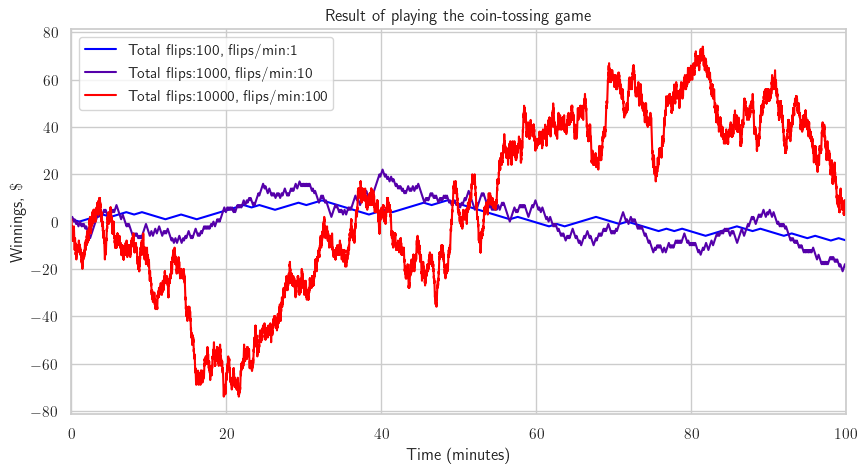

In [11]:
# Create a figure and axis objects with a specific size
fig, ax = plt.subplots(figsize=(10, 5))

# Set the number of coin flips
n_flips = 100

# Generate random coin flips and calculate the cumulative sum for the first set
s1 = np.cumsum(np.random.choice([-1, 1], size=(n_flips)))
i1 = np.linspace(0, n_flips, n_flips)

# Generate random coin flips and calculate the cumulative sum for the second set
s2 = np.cumsum(np.random.choice([-1, 1], size=(n_flips*10)))
i2 = np.linspace(0, n_flips, n_flips*10)

# Generate random coin flips and calculate the cumulative sum for the third set
s3 = np.cumsum(np.random.choice([-1, 1], size=(n_flips*100)))
i3 = np.linspace(0, n_flips, n_flips*100)

# Plot the first set of data
ax.plot(i1, s1,  label=f'Total flips:{i1.shape[0]}, flips/min:{i1.shape[0]/n_flips:.0f}')

# Plot the second set of data
ax.plot(i2, s2 , label=f'Total flips:{i2.shape[0]}, flips/min:{i2.shape[0]/n_flips:.0f} ')

# Plot the third set of data
ax.plot(i3, s3, c='red', label=f'Total flips:{i3.shape[0]}, flips/min:{i3.shape[0]/n_flips:.0f}')

# Set the x-axis limits
ax.set_xlim(0, n_flips)

# Set the title of the plot
ax.set_title(f'Result of playing the coin-tossing game')

# Set the y-axis label
ax.set_ylabel('Winnings, $\\$$')

# Set the x-axis label
ax.set_xlabel('Time (minutes)')

# Add a legend to the plot
plt.legend()

# Save the plot as an image file
plt.savefig('coin_tossing_game.png', dpi=DPI, bbox_inches='tight')

# Display the plot
plt.show()

### SDE realisations

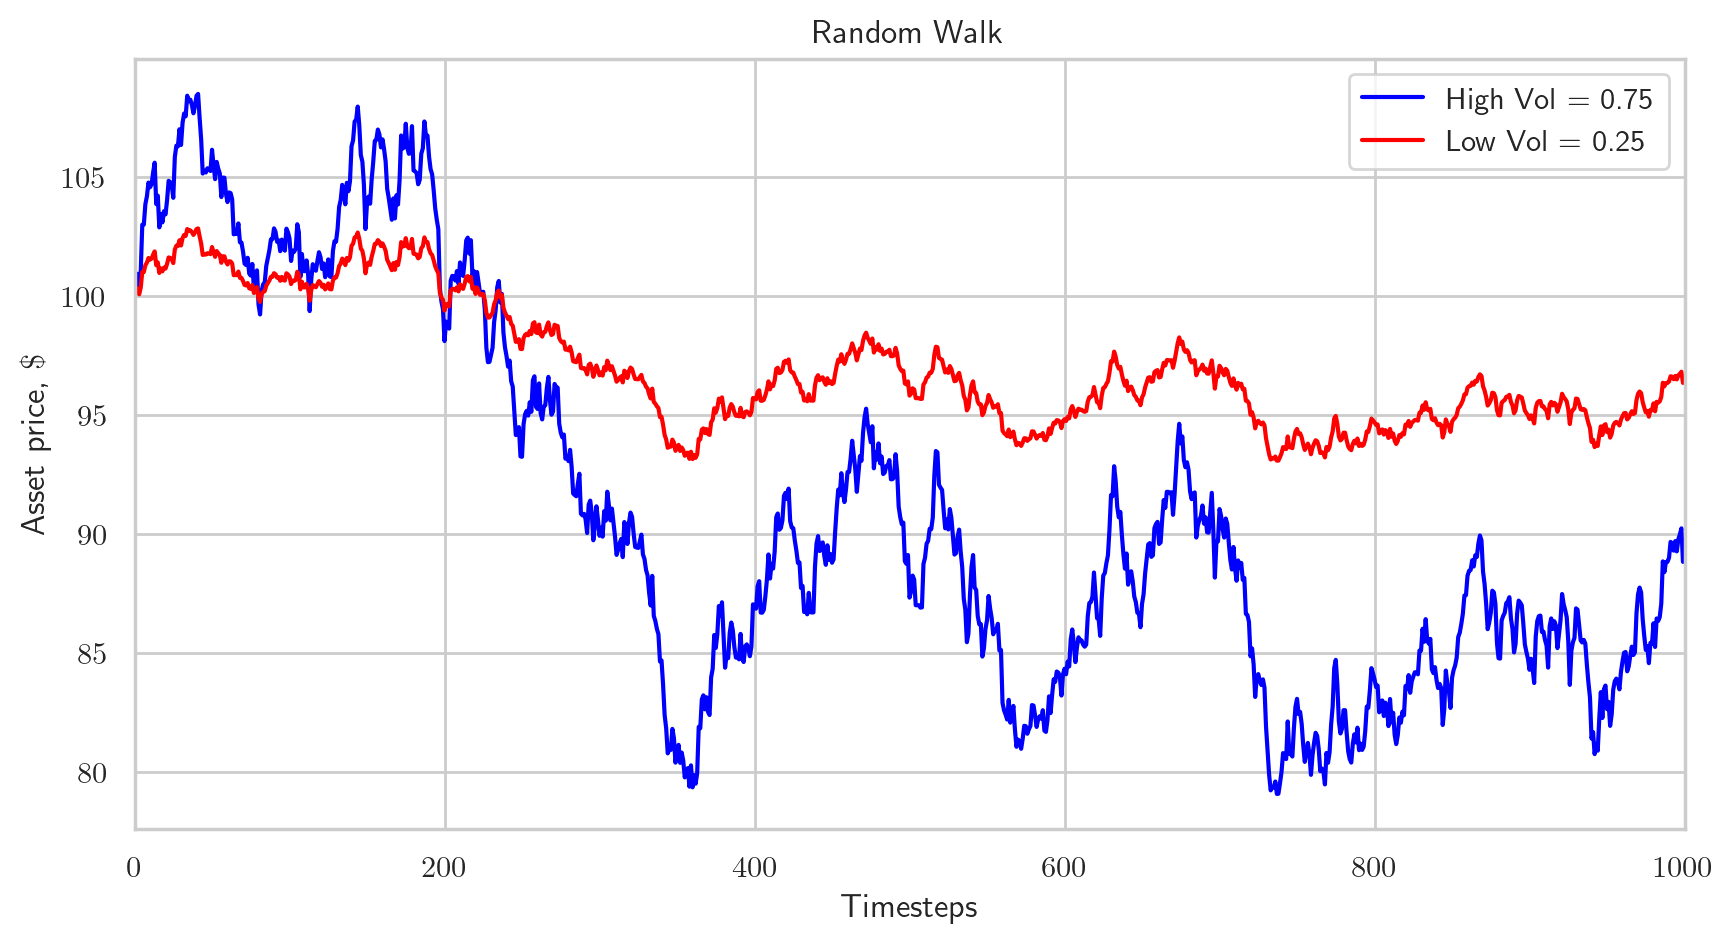

In [12]:
# Set the initial values for the variables
S0 = 100
mu = 0.1
sig1 = 0.25
sig2 = 0.75

# Set the number of time steps and the total time
N = 1000
t = 1

# Calculate the time step size
dt = t/N

# Generate an array of random numbers from a normal distribution
X = np.random.normal(0, 1, N+1)

# Create empty arrays to store the asset prices
S1 = np.empty(N)
S2 = np.empty(N)

# Set the initial values for the asset prices
S1[0] = S0
S2[0] = S0

# Perform the random walk simulation
for i in range(1, N):
    S1[i] = S1[i-1] + mu*dt + sig1 * X[i-1]
    S2[i] = S2[i-1] + mu*dt + sig2 * X[i-1]
    
# Create a new figure with a specific size and resolution
plt.figure(figsize=(10, 5), dpi=200)

# Plot the asset prices for the high volatility case
plt.plot(S2, alpha=1, c='blue', label='High Vol = 0.75')

# Plot the asset prices for the low volatility case
plt.plot(S1, alpha=1, c='red', label='Low Vol = 0.25')

# Add a legend to the plot
plt.legend()

# Set the x-axis limits
plt.xlim(0, N)

# Set the y-axis label
plt.ylabel('Asset price, $\$$')

# Set the x-axis label
plt.xlabel('Timesteps')

# Set the title of the plot
plt.title('Random Walk')

# Save the plot as an image file
plt.savefig('Geometric_brownian_motion.png', dpi=DPI, bbox_inches='tight')

# Display the plot
plt.show()

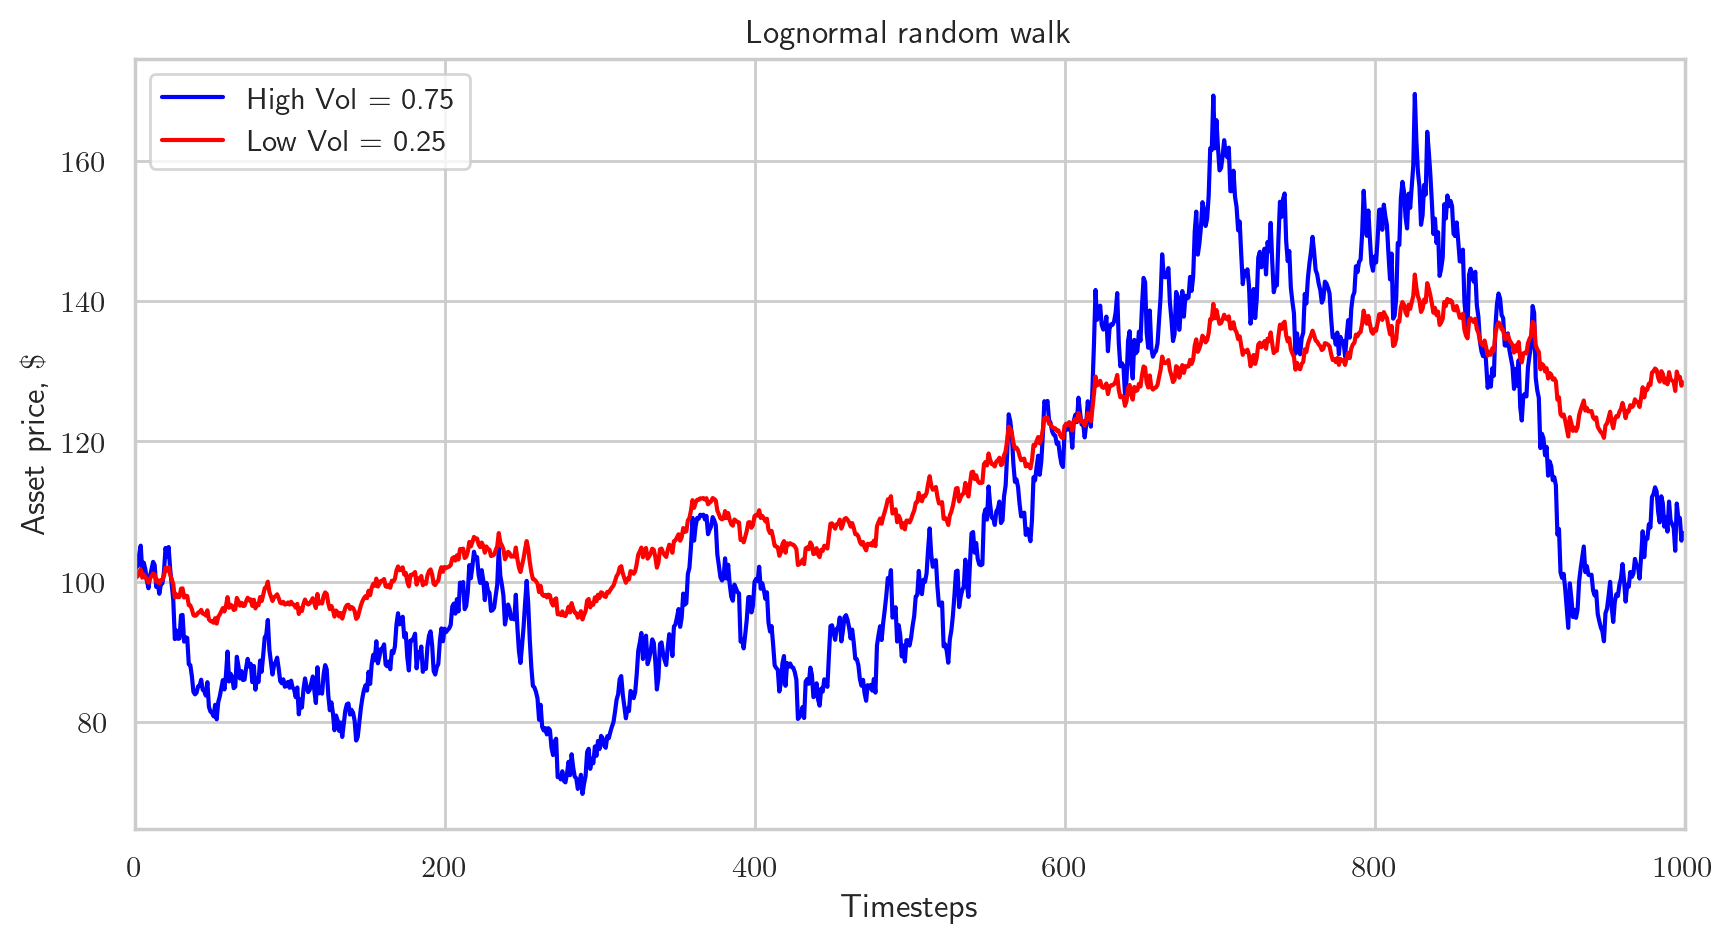

In [13]:
# Set the initial values for the variables
S0 = 100
mu = 0.25
sig1 = 0.25
sig2 = 0.75

# Set the number of time steps and the total time
N = 1000
t = 1

# Calculate the time step size
dt = t/N

# Generate an array of random numbers from a normal distribution
X = np.random.normal(0, 1, N+1)

# Create empty arrays to store the asset prices
S1 = np.empty(N)
S2 = np.empty(N)

# Set the initial values for the asset prices
S1[0] = S0
S2[0] = S0

# Perform the lognormal random walk simulation
for i in range(1, N):
    S1[i] = S1[i-1] + mu*S1[i-1]*dt + sig1*S1[i-1]*X[i]*np.sqrt(dt)
    S2[i] = S2[i-1] + mu*S2[i-1]*dt + sig2*S2[i-1]*X[i]*np.sqrt(dt)
    
# Create a new figure with a specific size and resolution
plt.figure(figsize=(10, 5), dpi=200)

# Plot the asset prices for the high volatility case
plt.plot(S2, alpha=1, c='blue', label='High Vol = 0.75')

# Plot the asset prices for the low volatility case
plt.plot(S1, alpha=1, c='red', label='Low Vol = 0.25')

# Add a legend to the plot
plt.legend()

# Set the x-axis limits
plt.xlim(0, N)

# Set the y-axis label
plt.ylabel('Asset price, $\$$')

# Set the x-axis label
plt.xlabel('Timesteps')

# Set the title of the plot
plt.title('Lognormal random walk')

# Save the plot as an image file
plt.savefig('lognormal_random_walk.png', dpi=DPI, bbox_inches='tight')

# Display the plot
plt.show()

### Lognormal random walk Monte Carlo sim

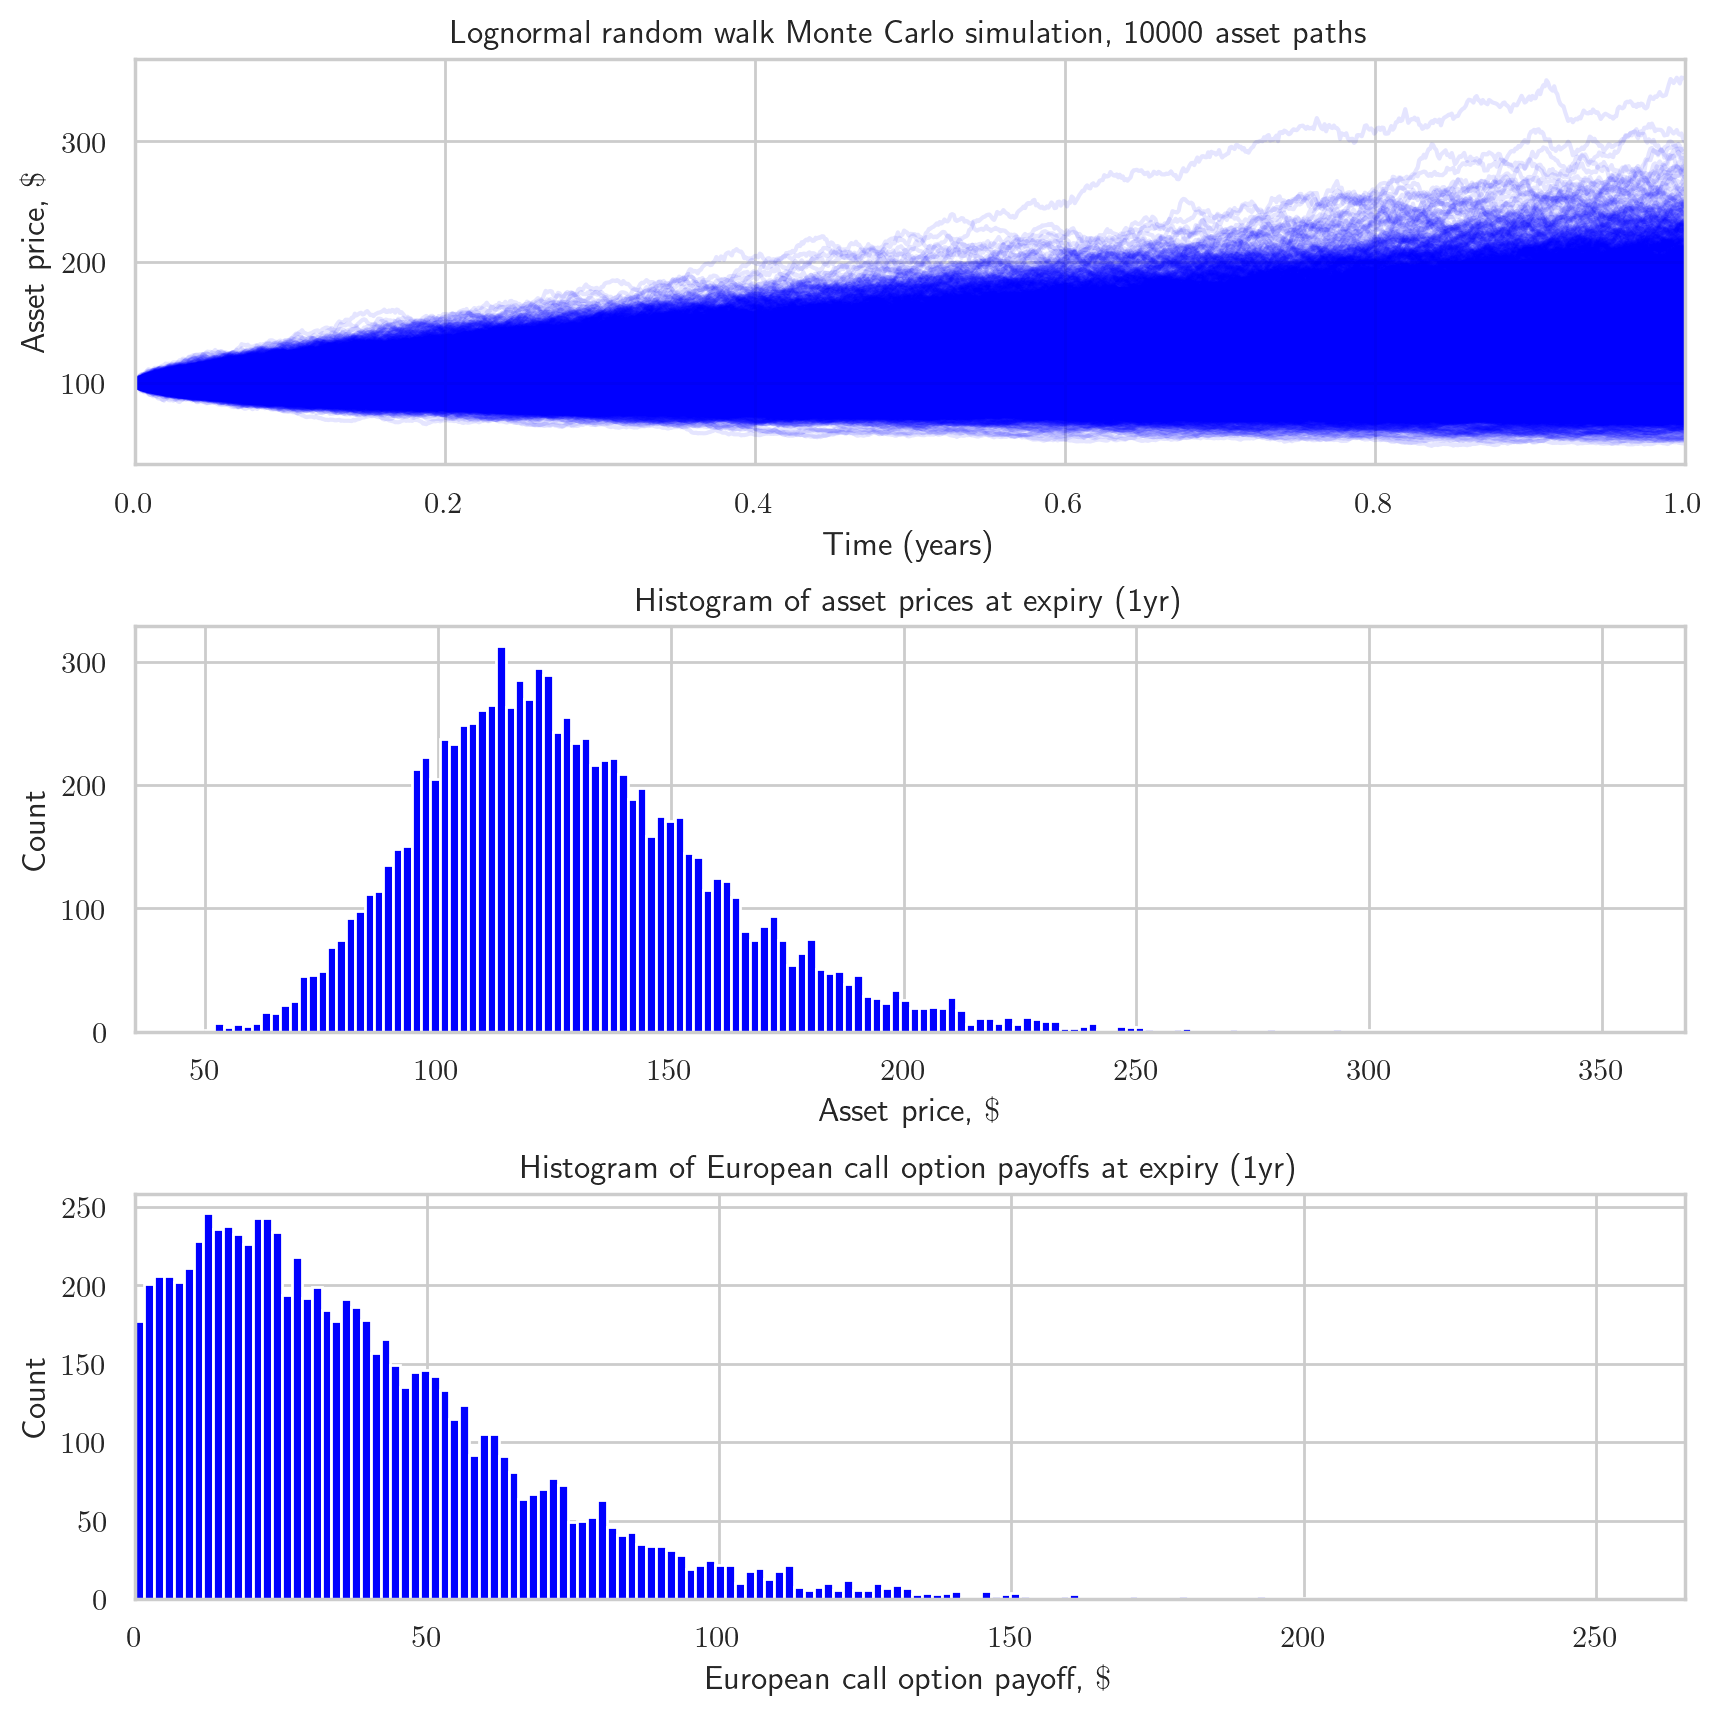

In [14]:
# Initializing variables
S0 = 100     # Initial asset price
mu = 0.25    # Drift parameter
sig = 0.25  # Volatility parameter for asset path
N = 1000     # Number of time steps
M = 10000    # Number of asset paths
t = 1        # Time horizon

# Time step size
dt = t/N  
# Generating random normal variables
X = np.random.normal(0, 1, (N+1, M))  

S = np.empty((N, M))  
 

S[0] = S0  # Setting initial asset price

# Generating asset paths
for i in range(1, N):
    S[i] = S[i-1] + mu*S[i-1]*dt + sig*S[i-1]*X[i]*np.sqrt(dt)

# Plotting asset paths
fig, axs = plt.subplots(3, 1, figsize=(10, 10), dpi=200)
plt.subplots_adjust(hspace=0.4)
axs[0].plot(np.linspace(0, t, N), S, alpha=0.1, c='blue', label='Asset path')
axs[0].set_xlim(0, t)
axs[0].set_ylabel('Asset price, $\$$')
axs[0].set_xlabel('Time (years)')
axs[0].set_title(f'Lognormal random walk Monte Carlo simulation, {M} asset paths')

# Plotting histogram of asset prices at expiry
axs[1].hist(S[-1], bins=150, color='blue', label='Asset price')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Asset price, $\$$')
axs[1].set_title('Histogram of asset prices at expiry (1yr)')

# Calculating and plotting histogram of option payoffs at expiry
payoff = np.maximum(S[-1]-100, 0)
axs[2].hist(payoff[payoff!=0], bins=150, color='blue')
axs[2].set_ylabel('Count')
axs[2].set_xlabel('European call option payoff, $\$$')
axs[2].set_title('Histogram of European call option payoffs at expiry (1yr)')
axs[2].set_xlim(0)

# Saving and displaying the plot
plt.savefig('lognormal_random_walk_MC.png', dpi=DPI, bbox_inches='tight')
plt.show()

### Heston model calibration to market


To increase the speed of the calibration process I chose to write the Heston model pricer as a Monte Carlo simulation in the C programming language, then compile it as a shared library. The C code reads,

```
#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#include <float.h>
#include <stdbool.h>
#include <time.h>

double heston_mc(double S0, double K, double r, double v0, double rho, double kappa, double theta, double sigma, double T, int N, int M) {

    double dt = T / N; // Time step
    double price = 0; // Accumulator variable for option price
    
    // Monte Carlo simulation loop
    for (int i = 0; i < M; i++) {
        double S = S0; // Stock price
        double v = v0; // Volatility
        bool skipPath = false; // Flag to indicate if a path needs to be skipped
        double constants1 = 2 * PI; // Constant for calculations
        double constants2 = sqrt(1 - rho * rho); // Constant for calculations
        
        // Path simulation loop
        for (int j = 0; j < N; j++) {
            double u, v1, v2, R, ta, x, y; // Variables for random number generation and calculations
            
            // Generate random numbers
            u = drand48() * 2 - 1; // Random number between -1 and 1
            v1 = drand48() * 2 - 1; // Random number between -1 and 1
            v2 = drand48() * 2 - 1; // Random number between -1 and 1
            
            // Perform calculations
            R = sqrt(-2 * log(1 - u * u)); // Random variable R
            ta = constants1 * v1; // Angle ta
            x = R * cos(ta); // Random variable x
            y = rho * x + constants2 * R * sin(ta); // Random variable y
            
            // Update stock price and volatility
            S *= exp((r - 0.5 * v) * dt + sqrt(v * dt) * x); 
            v += kappa * (theta - (v > 0 ? v : 0)) * dt + sigma * sqrt((v > 0 ? v : 0) * dt) * v2; 
            
            // Check for NaN (Not a Number) volatility
            if (isnan(v)) {
                skipPath = true; // Flag the path to be skipped
                break; // Exit the inner loop
            }
        }
        
        // Calculate payoff and update price
        if (!skipPath) {
            double payoff = S - K; // Option payoff
            price += payoff > 0 ? payoff : 0; // Add positive payoffs to the price accumulator
        }
    }
    
    // Calculate and return the option price
    return exp(-r * T) * (price / M);
}
```

To complile this into a shared library, save the above code into a C file called heston_mc.c, and run the following command in the terminal:

```
gcc -O3 -shared -o heston_mc.so -fPIC heston_mc.c -lm
```
This will compile the C code into a shared library, that we can then import into Python.

In [15]:
import ctypes

# Load the shared library containing the heston_mc function
heston_lib = ctypes.CDLL("./heston_mc.so")

# Define the heston_mc function from the shared library
heston_price_c = heston_lib.heston_mc

# Set the return type of the heston_mc function to double
heston_price_c.restype = ctypes.c_double

# Set the argument types of the heston_mc function
heston_price_c.argtypes = (
    ctypes.c_double,  # S0: Initial stock price
    ctypes.c_double,  # K: Strike price
    ctypes.c_double,  # r: Risk-free interest rate
    ctypes.c_double,  # v0: Initial volatility
    ctypes.c_double,  # rho: Correlation coefficient
    ctypes.c_double,  # kappa: Mean reversion speed
    ctypes.c_double,  # theta: Long-term average volatility
    ctypes.c_double,  # sigma: Volatility of volatility
    ctypes.c_double,  # T: Time to maturity
    ctypes.c_int,     # N: Number of timesteps
    ctypes.c_int      # M: Number of simulations
)

In [16]:
def heston_price_wrapper(*args):
    return heston_price_c(*args)

def heston_price_vec_MP(S0, strikes, expiries, r, v0, kappa, theta, sigma, rho):
    """
    Calculate Heston option prices using multiprocessing.

    Args:
        S0 (float): Initial stock price.
        strikes (numpy.array): Array of strike prices.
        expiries (numpy.array): Array of time to maturity values.
        r (float): Risk-free interest rate.
        v0 (float): Initial volatility.
        kappa (float): Mean reversion speed.
        theta (float): Long-term average volatility.
        sigma (float): Volatility of volatility.
        rho (float): Correlation coefficient.

    Returns:
        numpy.array: Array of calculated option prices corresponding to the given strikes and expiries.
    """
    prices = np.empty_like(strikes)  # Initialize array to store option prices
    N = 252  # Number of time steps
    M = 1000  # Number of simulations
    args_list = [(S0, K, r, v0, rho, kappa, theta, sigma, T, N, M) for K, T in zip(strikes, expiries)]

    with Pool(8) as pool:  # Create a pool of workers
        results = pool.starmap(heston_price_wrapper, args_list)  # Use the pool to parallelize the computations

    prices = np.array(results)  # Convert the results list to a numpy array
    return prices

        

In [17]:
def calibrate_heston(S0, r, data):
    """
    Calibrate Heston model parameters using the COBYLA algorithm.

    Args:
        S0 (float): Initial stock price.
        r (float): Risk-free interest rate.
        data (pandas.DataFrame): DataFrame containing option data including strikes, prices, and expiries.

    Returns:
        tuple: Tuple containing the calibrated Heston model parameters (v0, kappa, theta, sigma, rho, lambd).
    """
    def error(x):
        """
        Error function to be minimized during calibration.

        Args:
            x (list or numpy.array): List or array containing the Heston model parameters (v0, kappa, theta, sigma, rho, lambd).

        Returns:
            float: Mean squared error between the observed option prices and the model prices.
        """
        # Extract the arguments for heston_price_vec_MP
        v0, kappa, theta, sigma, rho = x
        # Calculate model prices
        model = heston_price_vec_MP(S0, strikes, expiries, r, v0, kappa, theta, sigma, rho)
        # Calculate MSE and return
        err = np.mean((prices - model) ** 2)
        return err

    # Extract option data
    strikes = data.strike.values
    prices = data.lastPrice.values
    expiries = data.daysToExpiration.values / 365

    # Define bounds for parameter optimization
    bounds = ((1e-5, 1), (1e-5, 3), (1e-5, 1), (1e-5, 1), (-1, 1))

    # Extract lower and upper bounds for each parameter
    xl = [i[0] for i in bounds]
    xu = [i[1] for i in bounds]

    # Initial guess for optimization
    x0 = np.array(xu) / 2

    # Define options for COBYLA algorithm
    options = {
        'disp': True,
        'rhobeg': 2.0,
        'rhoend': 1e-8,
    }

    # Perform parameter optimization using COBYLA
    res = cobyqa.minimize(error, x0, xl=xl, xu=xu, options=options, eta1=0.2, eta2=0.5)

    # Return the calibrated model parameters
    return tuple(res.x)

# Cut the calls dataframe to reduce calibration time 
calls_cut = calls[calls.daysToExpiration < 150]
# Calibrate the Heston model to the option prices
calibration_results = calibrate_heston(174, 0.04, calls_cut)

error([0.500005 1.5      0.500005 0.500005 0.5     ]) = 45.85971238743923
error([1.       1.5      0.500005 0.500005 0.5     ]) = 69.16919538488617
error([0.500005 1.999995 0.500005 0.500005 0.5     ]) = 45.87033020180006
error([0.500005 1.5      1.       0.500005 0.5     ]) = 49.64107926435099
error([0.500005 1.5      0.500005 1.       0.5     ]) = 45.54975411681169
error([0.500005 1.5      0.500005 0.500005 0.999995]) = 45.85971238743923
error([1.00000e-05 1.50000e+00 5.00005e-01 5.00005e-01 5.00000e-01]) = 32.51403343032369
error([0.500005 1.000005 0.500005 0.500005 0.5     ]) = 45.84801532993038
error([5.00005e-01 1.50000e+00 1.00000e-05 5.00005e-01 5.00000e-01]) = 42.37063592565528
error([5.00005e-01 1.50000e+00 5.00005e-01 1.00000e-05 5.00000e-01]) = 46.04083936796668
error([5.00005e-01 1.50000e+00 5.00005e-01 5.00005e-01 5.00000e-06]) = 45.85971238743923
error([1.00000000e-05 1.49846888e+00 1.14903597e-03 5.33700443e-01
 5.00000000e-01]) = 1663.4758647877625

New trust-region ra

### Visualising the calibration results

100%|███████████████████████████████████████████| 18/18 [00:01<00:00, 10.07it/s]


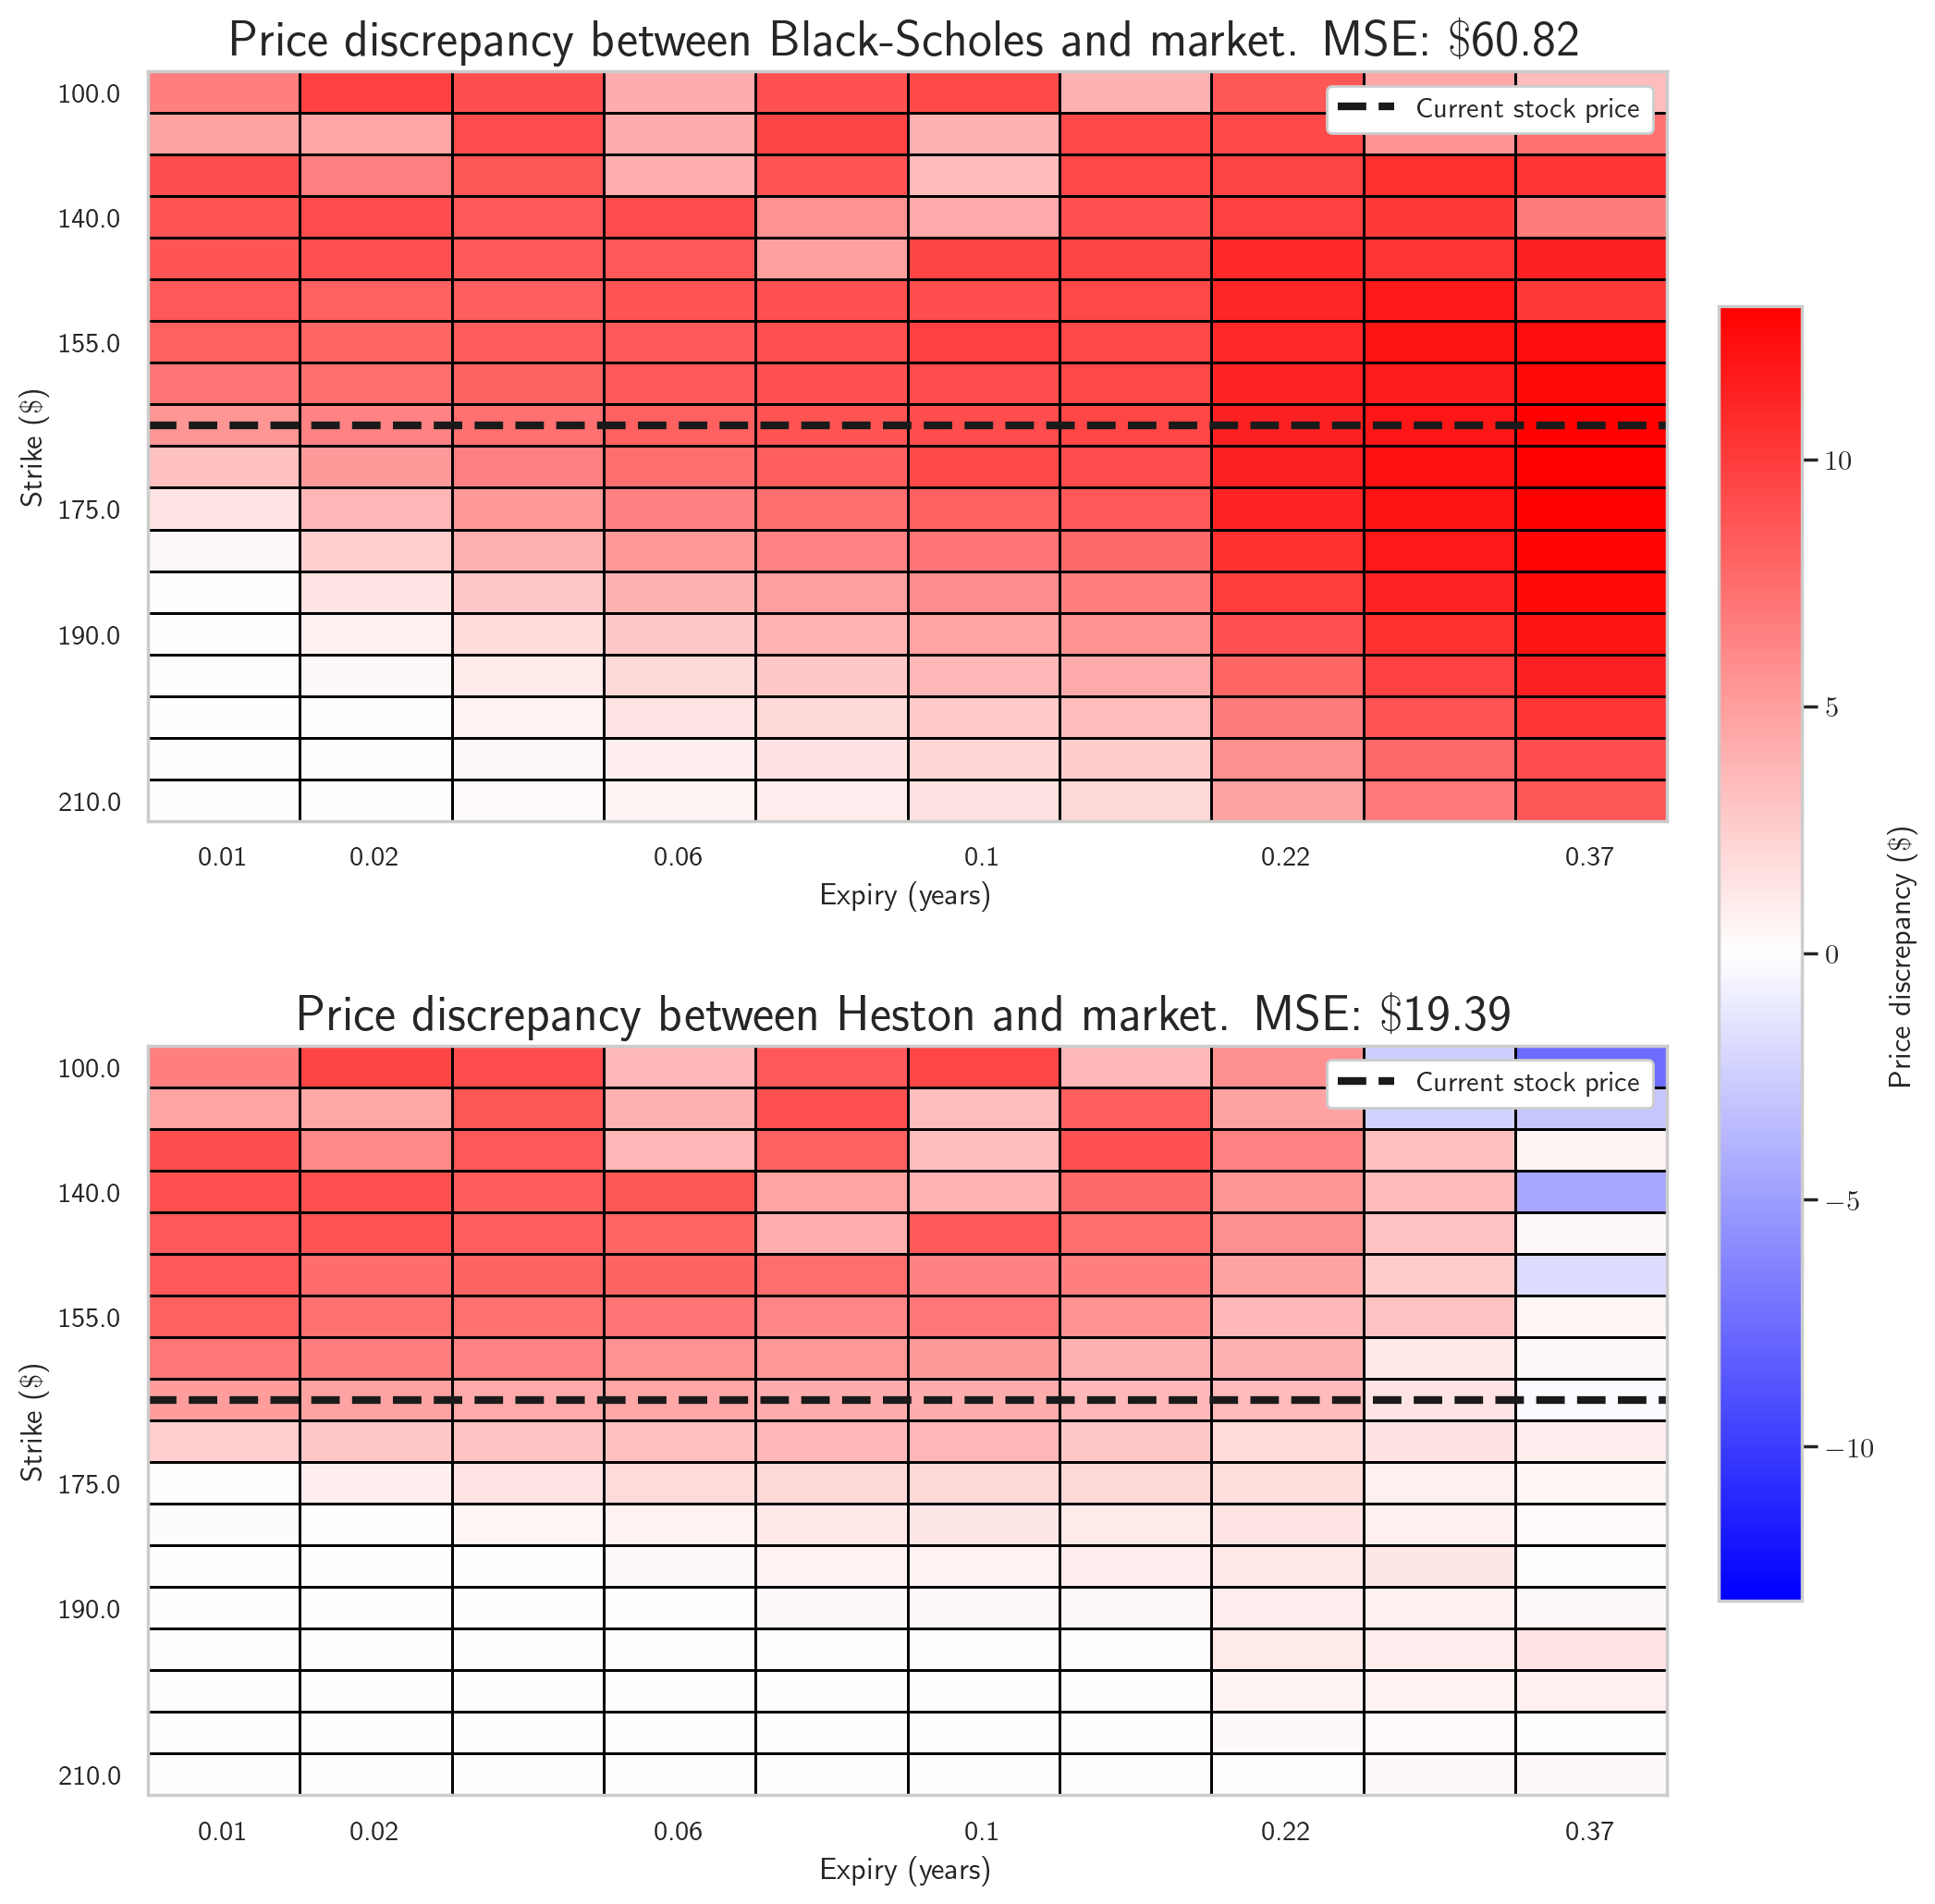

In [18]:
# Create a price surface using pivot_table
price_surface = (
    calls_cut[['daysToExpiration', 'strike', 'lastPrice']]
    .pivot_table(values='lastPrice', index='strike', columns='daysToExpiration')
    .dropna()
)

# Create a surface using pivot_table
surface = (
    calls_cut[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# Extract prices, strikes, and expiries from the price surface
prices, strikes, expiries = price_surface.values, price_surface.index, price_surface.columns

# Calculate the average implied volatility
iv = np.mean(surface.values)

def grid(ax):
    # Function to draw grid lines on the plot
    rows, cols = prices.shape
    for i in range(rows):
        for j in range(cols):
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, edgecolor='black', linewidth=1, fill=False)
            ax.add_patch(rect)

    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)

# Calculate Black-Scholes prices
bs_prices = np.empty_like(prices)
for i in tqdm(range(bs_prices.shape[0])):
    bs_prices[i] = BlackScholesPricer(
        current_price,
        strikes[i],
        expiries/365,
        0.04,
        iv
    ).option_price

# Extract calibration results
v0, kappa, theta, sigma, rho = calibration_results

# Calculate Heston prices
heston_prices = np.empty_like(prices)
for i in tqdm(range(bs_prices.shape[0])):
    for j in range(bs_prices.shape[1]):
        heston_prices[i, j] = heston_price_c(
            current_price,
            strikes[i],
            0.04,
            v0,
            rho,
            kappa,
            theta,
            sigma,
            expiries[j]/365,
            252,
            1000,
        )
        
# Create subplots for two plots
fig, axs = plt.subplots(2, 1, figsize=(9, 10), dpi=200)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Colors for the cmap
colors = ['blue', 'white', 'red']

# Create the colormap object
cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

# Find the minimum and maximum values for the color normalization
vmin = np.min([np.min(bs_prices-prices), np.min(heston_prices-prices)])
vmax = np.max([np.max(bs_prices-prices), np.max(bs_prices-prices)])

# Calculate the absolute maximum value and set the center for the color normalization
vmax_abs = max(abs(vmin), abs(vmax))
center = 0.0

# Create a diverging normalization centered at zero
cnorm = mcolors.TwoSlopeNorm(vmin=-vmax_abs, vcenter=center, vmax=vmax_abs)

# Reset the value of the 'center' variable
center = 0.0

# Plot the first subplot with the colormap, aspect ratio, and color normalization
im1 = axs[0].imshow(bs_prices - prices, cmap=cmap, aspect='auto', norm=cnorm)

# Add a grid to the plot
grid(axs[0])

# Disable the grid lines
axs[0].grid(False)

# Set the y-axis tick locations and labels
ytick_loc = np.linspace(0, price_surface.shape[0]-1, 6, dtype=np.int64)
axs[0].set_yticks(ytick_loc, labels=strikes[ytick_loc])

# Set the x-axis tick locations and labels
xtick_loc = np.linspace(0, price_surface.shape[1]-1, 6, dtype=np.int64)
axs[0].set_xticks(xtick_loc, labels=(np.round(expiries[xtick_loc]/365, 2)))

# Set the x and y labels for the first subplot
axs[0].set_xlabel('Expiry (years)')
axs[0].set_ylabel('Strike ($\\$$)')

# Add a horizontal line indicating the current stock price
axs[0].axhline(y=8, c='k', linewidth=3, linestyle='--', label='Current stock price')

# Add a legend to the first subplot
axs[0].legend(framealpha=1)

# Set the title for the first subplot, including the mean squared error value
axs[0].set_title(f'Price discrepancy between Black-Scholes and market. MSE: $\\$${np.mean((bs_prices-prices)**2):.2f}', fontsize=20)

# Plot the second subplot with the colormap, aspect ratio, and color normalization
im2 = axs[1].imshow(heston_prices - prices, cmap=cmap, aspect='auto', norm=cnorm)

# Add a grid to the plot
grid(axs[1])

# Disable the grid lines
axs[1].grid(False)

# Set the y-axis tick locations and labels
ytick_loc = np.linspace(0, price_surface.shape[0]-1, 6, dtype=np.int64)
axs[1].set_yticks(ytick_loc, labels=strikes[ytick_loc])

# Set the x-axis tick locations and labels
xtick_loc = np.linspace(0, price_surface.shape[1]-1, 6, dtype=np.int64)
axs[1].set_xticks(xtick_loc, labels=(np.round(expiries[xtick_loc]/365, 2)))

# Set the x and y labels for the second subplot
axs[1].set_xlabel('Expiry (years)')
axs[1].set_ylabel('Strike ($\\$$)')

# Add a horizontal line indicating the current stock price
axs[1].axhline(y=8, c='k', linewidth=3, linestyle='--', label='Current stock price')

# Add a legend to the second subplot
axs[1].legend(framealpha=1)

# Set the title for the second subplot, including the mean squared error value
axs[1].set_title(f'Price discrepancy between Heston and market. MSE: $\\$${np.mean((heston_prices-prices)**2):.2f}', fontsize=20)

# Create a colorbar axis for the figure
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])

# Add a colorbar to the figure using the second subplot's color map
cbar = fig.colorbar(im2, cax=cbar_ax)

# Set the label for the colorbar
cbar.set_label('Price discrepancy ($\\$$)')

# Save the figure as an image file
plt.savefig('BS_heston_discrepancy.png', dpi=DPI, bbox_inches='tight')

# Display the plot
plt.show()





### Plotting the volatility smile for the Heston model

Code to calculate the integral in the Heston model closed-form solution was provided by https://quantpy.com.au/stochastic-volatility-models/heston-model-calibration-to-option-prices/. 
Unfortunately the integral is unstable and calibration with this was tricky, so we resorted to Monte Carlo simulations.

In [19]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    """
    Compute the characteristic function for the Heston model.

    Parameters:
        phi (float): Integration variable.
        S0 (float): Spot price.
        v0 (float): Initial variance.
        kappa (float): Mean reversion speed of variance.
        theta (float): Long-term mean of variance.
        sigma (float): Volatility of variance.
        rho (float): Correlation between asset price and variance.
        lambd (float): Risk premium of variance.
        tau (float): Time to maturity.
        r (float): Risk-free interest rate.

    Returns:
        float: Value of the characteristic function.

    """
    # constants
    a = kappa * theta
    b = kappa + lambd

    # common terms w.r.t phi
    rspi = rho * sigma * phi * 1j

    # define d parameter given phi and b
    d = np.sqrt((rho * sigma * phi * 1j - b) ** 2 + (phi * 1j + phi ** 2) * sigma ** 2)

    # define g parameter given phi, b and d
    g = (b - rspi + d) / (b - rspi - d)

    # calculate characteristic function by components
    exp1 = np.exp(r * phi * 1j * tau)
    term2 = S0 ** (phi * 1j) * ((1 - g * np.exp(d * tau)) / (1 - g)) ** (-2 * a / sigma ** 2)
    exp2 = np.exp(a * tau * (b - rspi + d) / sigma ** 2 + v0 * (b - rspi + d) * (
            (1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau))) / sigma ** 2)
    return exp1 * term2 * exp2


def integrand(phi, S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    """
    Compute the integrand for the Heston model.

    Parameters:
        phi (float): Integration variable.
        S0 (float): Spot price.
        K (float): Strike price.
        v0 (float): Initial variance.
        kappa (float): Mean reversion speed of variance.
        theta (float): Long-term mean of variance.
        sigma (float): Volatility of variance.
        rho (float): Correlation between asset price and variance.
        lambd (float): Risk premium of variance.
        tau (float): Time to maturity.
        r (float): Risk-free interest rate.

    Returns:
        float: Value of the integrand.

    """
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r * tau) * heston_charfunc(phi - 1j, *args) - K * heston_charfunc(phi, *args)
    denominator = 1j * phi * K ** (1j * phi)
    return numerator / denominator


def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    """
    Compute the price of a European call option in the Heston model.

    Parameters:
        S0 (float): Spot price.
        K (float): Strike price.
        v0 (float): Initial variance.
        kappa (float): Mean reversion speed of variance.
        theta (float): Long-term mean of variance.
        sigma (float): Volatility of variance.
        rho (float): Correlation between asset price and variance.
        lambd (float): Risk premium of variance.
        tau (float): Time to maturity.
        r (float): Risk-free interest rate.

    Returns:
        float: Option price.

    """
    args = (S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)

    real_integral, err = np.real(quad(integrand, 0, 100, args=args))

    return (S0 - K * np.exp(-r * tau)) / 2 + real_integral / np.pi


def Heston_implied_vol(S0, Ks, v0, kappa, theta, sigma, rho, lambd, tau, r):
    """
    Compute the implied volatility for a range of strike prices in the Heston model.

    Parameters:
        S0 (float): Spot price.
        Ks (ndarray): Array of strike prices.
        v0 (float): Initial variance.
        kappa (float): Mean reversion speed of variance.
        theta (float): Long-term mean of variance.
        sigma (float): Volatility of variance.
        rho (float): Correlation between asset price and variance.
        lambd (float): Risk premium of variance.
        tau (float): Time to maturity.
        r (float): Risk-free interest rate.

    Returns:
        ndarray: Array of implied volatilities.

    """
    prices = np.zeros_like(Ks)
    for i, K in enumerate(Ks):
        prices[i] = heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
    implied_volatility = implied_vol(prices, S0, Ks, tau, r, flag='c', return_as='numpy')
    return implied_volatility


/Users/ollie/miniconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:575: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


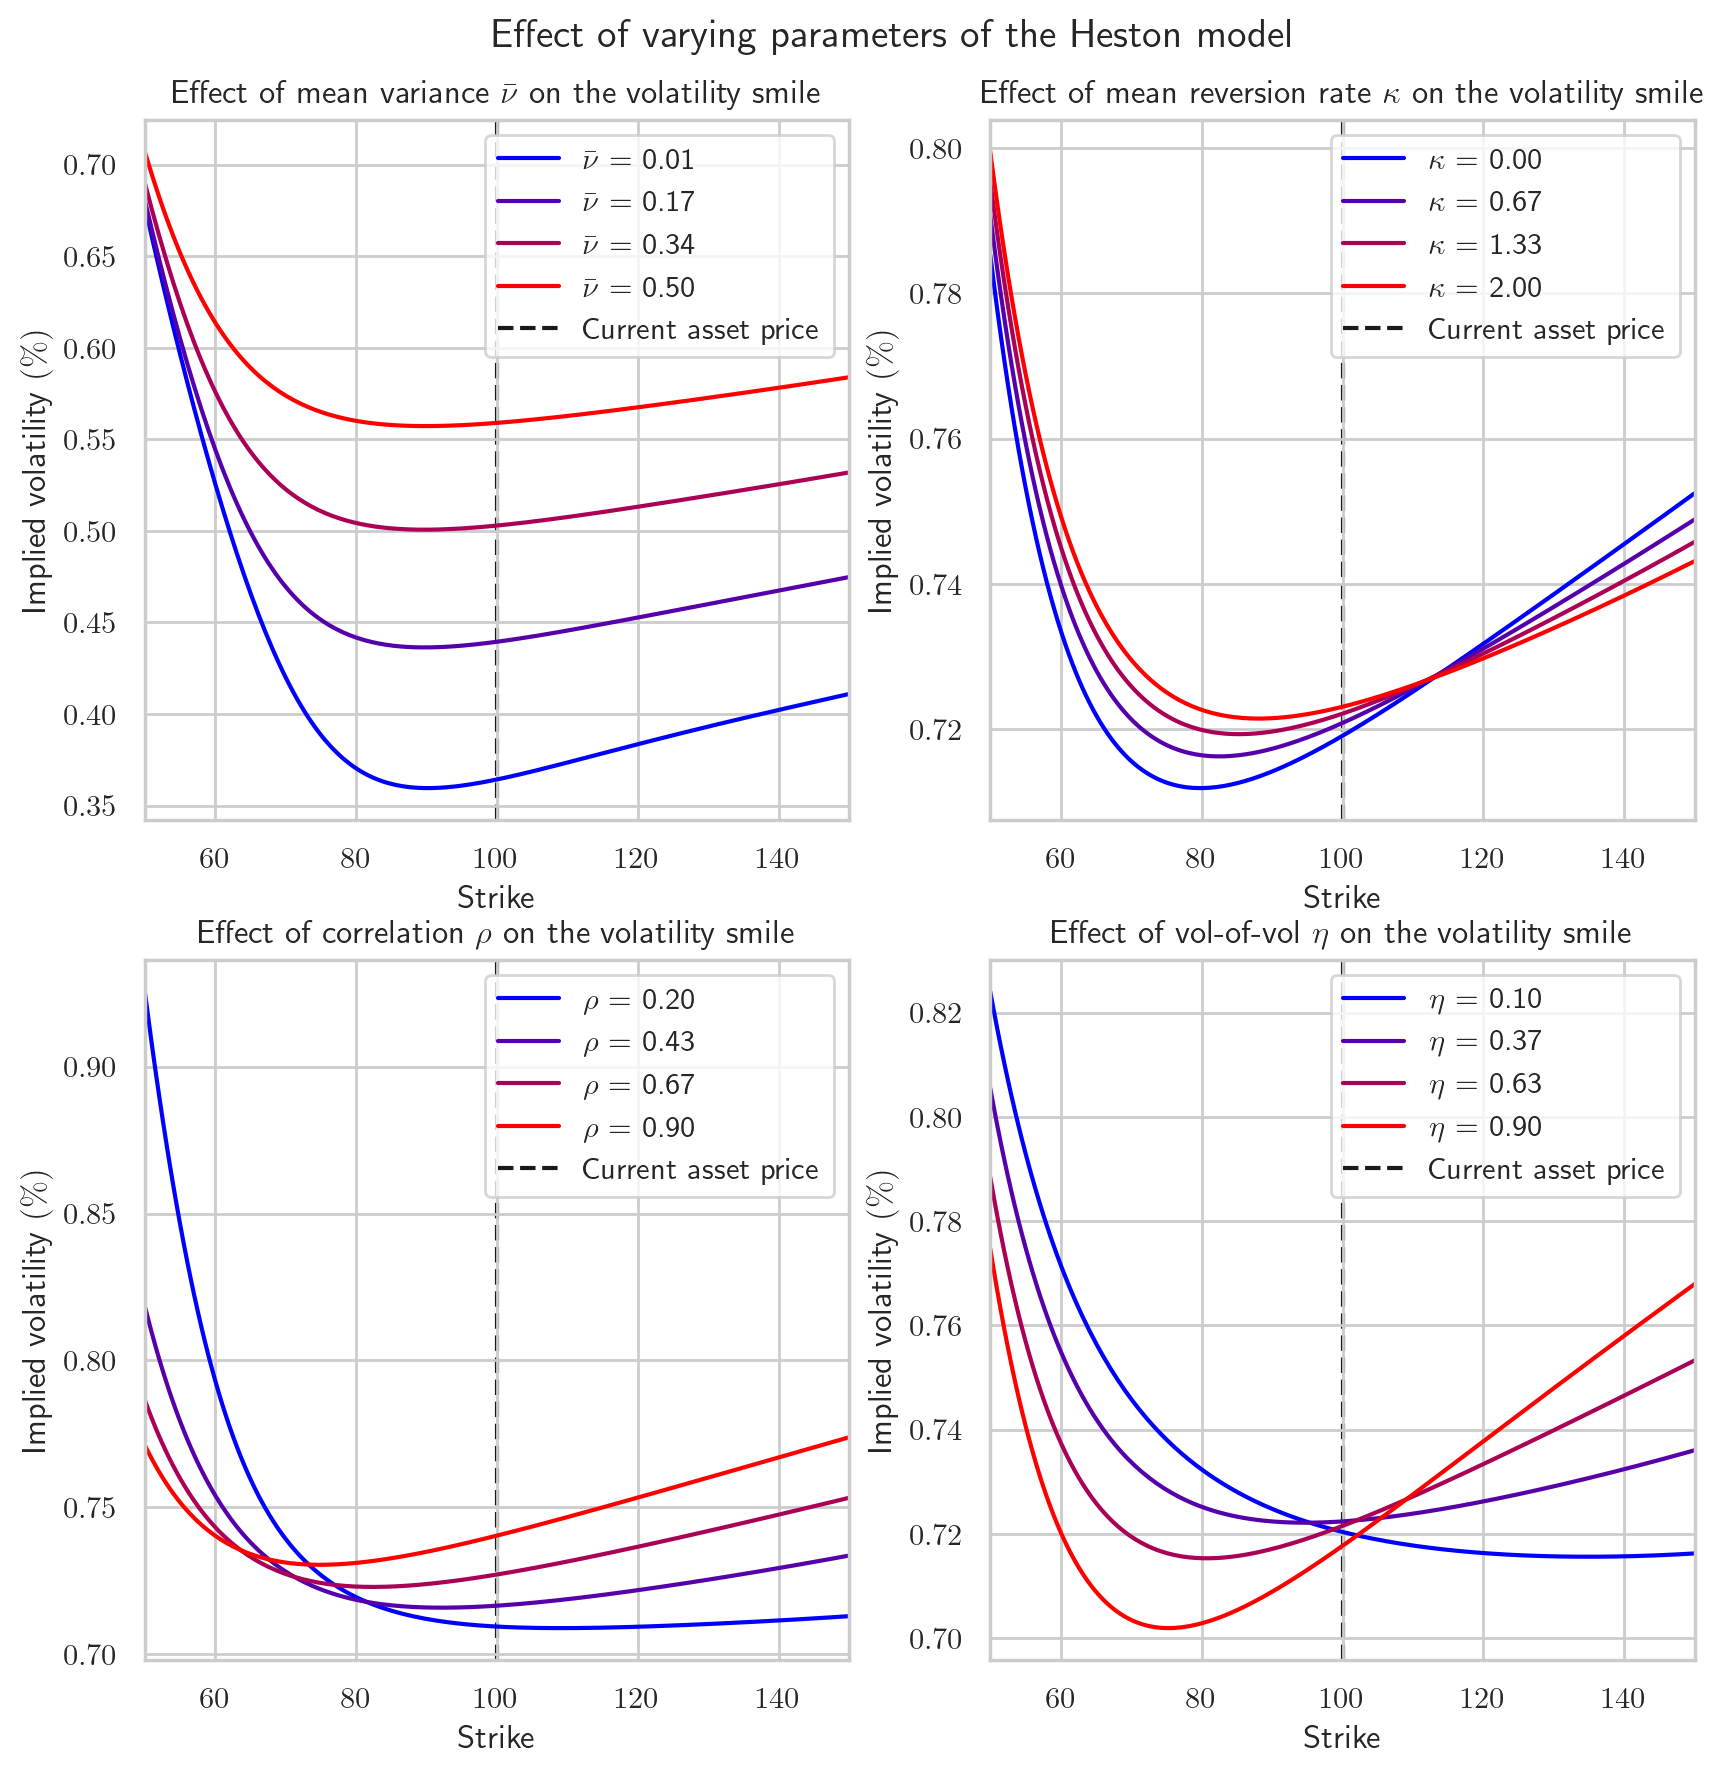

In [20]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)

n = 4
cs = cmap(np.linspace(0, 1, n))  # Color map
nus = np.linspace(0.01, 0.5, n)  # Values for mean variance
kappas = np.linspace(0, 2, n)  # Values for mean reversion rate
rhos = np.linspace(0.2, 0.9, n)  # Values for correlation
sigmas = np.linspace(0.1, 0.9, n)  # Values for volatility of volatility

# Parameters to test model
S0 = 100.      # Initial asset price
v0 = 0.2       # Initial variance
r = 0.03       # Risk-free rate
kappa = 1.5768 # Rate of mean reversion of variance process
theta = 0.2    # Long-term mean variance
sigma = 0.5    # Volatility of volatility
lambd = 0.1    # Risk premium of variance
rho = 0.5711   # Correlation between variance and stock process
tau = 1.       # Time to maturity

# Strikes
Ks = np.linspace(50, 150, 200)

# Loop over values of mean variance (nus)
for i, theta in enumerate(nus):
    vol = Heston_implied_vol(S0, Ks, v0, kappa, theta, sigma, rho, lambd, rho, r)
    axs[0, 0].plot(Ks, vol, label=r"$\bar\nu$ = " + f'{theta:.2f}')

v0 = 0.5

# Loop over values of mean reversion rate (kappas)
for kappa in kappas:
    vol = Heston_implied_vol(S0, Ks, v0, kappa, theta, sigma, rho, lambd, rho, r)
    axs[0, 1].plot(Ks, vol, label=r"$\kappa$ = " + f'{kappa:.2f}')

kappa = 1.5

# Loop over values of correlation (rhos)
for rho in rhos:
    vol = Heston_implied_vol(S0, Ks, v0, kappa, theta, sigma, rho, lambd, rho, r)
    axs[1, 0].plot(Ks, vol, label=r"$\rho$ = " + f'{rho:.2f}')

rho = 0.57

# Loop over values of volatility of volatility (sigmas)
for sigma in sigmas:
    vol = Heston_implied_vol(S0, Ks, v0, kappa, theta, sigma, rho, lambd, rho, r)
    axs[1, 1].plot(Ks, vol, label=r"$\eta$ = " + f'{sigma:.2f}')

# Set titles for each subplot
axs[0, 0].set_title(r'Effect of mean variance $\bar\nu$ on the volatility smile')
axs[0, 1].set_title(r'Effect of mean reversion rate $\kappa$ on the volatility smile')
axs[1, 0].set_title(r'Effect of correlation $\rho$ on the volatility smile')
axs[1, 1].set_title(r'Effect of vol-of-vol $\eta$ on the volatility smile')

# Set labels, vertical lines, legends, and x-limits for each subplot
for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel(r'Strike')
        axs[i, j].set_ylabel(r'Implied volatility $(\%)$')
        axs[i, j].axvline(x=S0, c='k', label='Current asset price', linestyle='--', zorder=0)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(Ks.min(), Ks.max())

# Set the main title
plt.suptitle('Effect of varying parameters of the Heston model', y=0.93)

# Save and display the plot
plt.savefig('Heston_params.png', dpi=DPI, bbox_inches='tight')
plt.show()

### Heston Monte-Carlo

In [21]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Simulates stock prices and variances using the Heston model.
    Thanks to https://www.codearmo.com/python-tutorial/heston-model-simulation-python

    Parameters:
    - S0 (float): Initial stock price.
    - v0 (float): Initial variance.
    - rho (float): Correlation between the stock price and the variance.
    - kappa (float): Mean-reversion speed of the variance.
    - theta (float): Long-term mean of the variance.
    - sigma (float): Volatility of the variance.
    - T (float): Time horizon in years.
    - N (int): Number of time steps.
    - M (int): Number of simulation paths.

    Returns:
    - S (ndarray): Array of simulated stock prices with shape (N+1, M).
    - v (ndarray): Array of simulated variances with shape (N+1, M).
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)
    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

In [22]:
S0 = 100.0        
T = 0.5           
r = 0.02          
N = 252           
M = 10000         
kappa = 4         
theta = 0.2**2    
v0 = 0.25**2      
rho = 0.9         
sigma = 0.9 

kappa = 1.5768  # Rate of mean reversion of variance process
theta = 0.2  # Long-term mean variance
sigma = 0.5  # Volatility of volatility
rho = 0.5711  # Correlation between variance and stock process

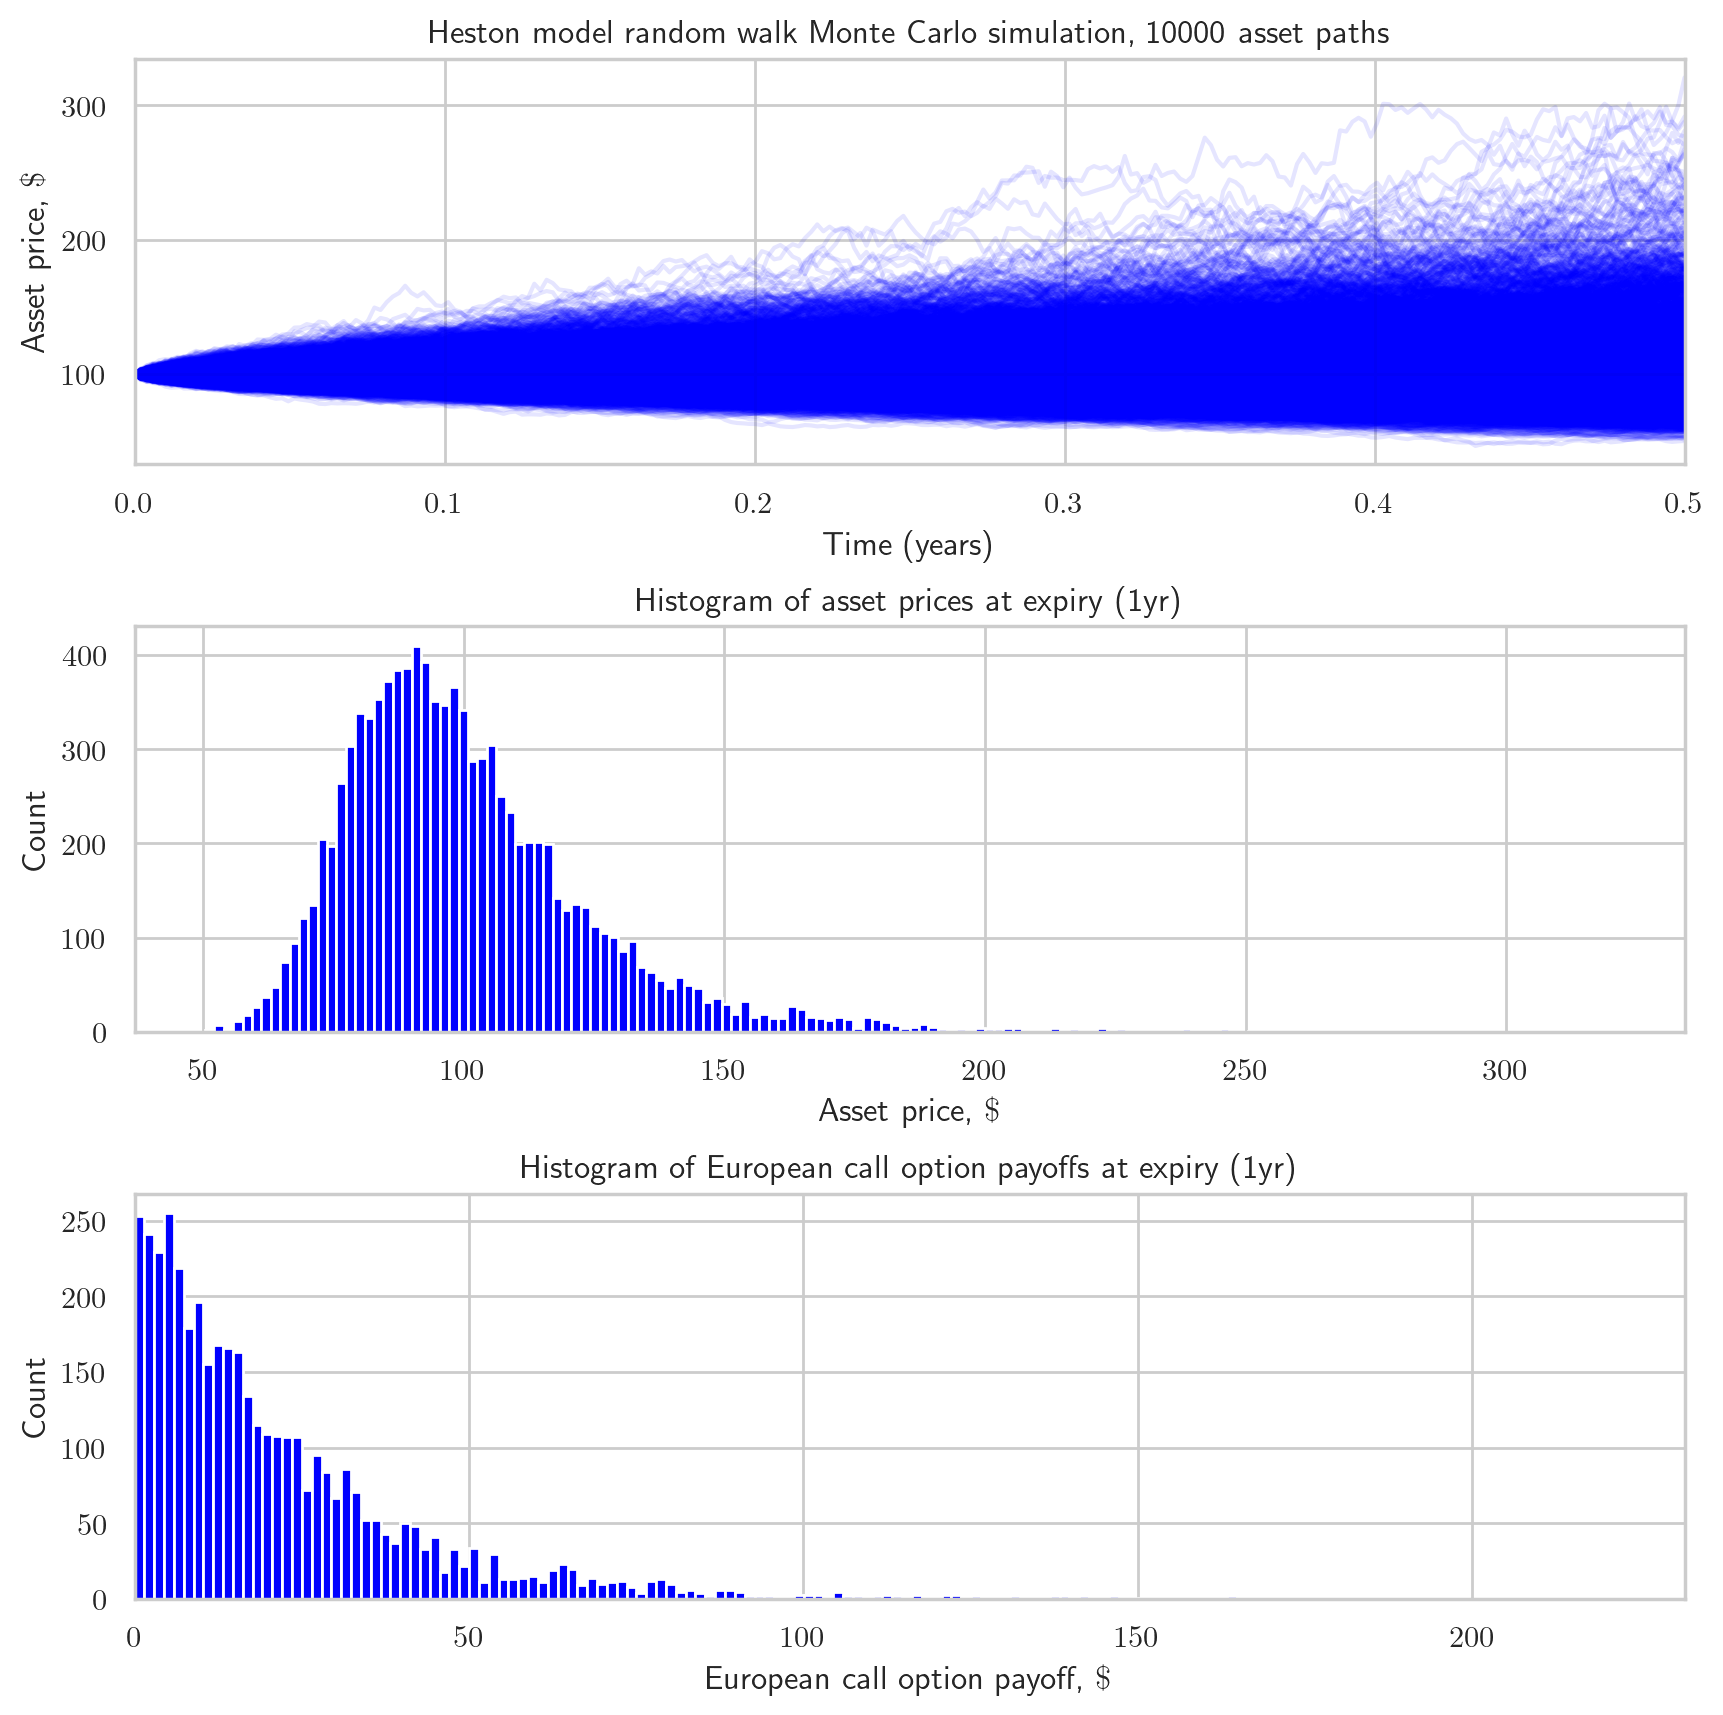

In [23]:
# Setting initial values
S0 = 100.0        # Initial asset price
T = 0.5           # Time to expiry (in years)
r = 0.02          # Risk-free interest rate
N = 252           # Number of time steps
M = 10000         # Number of asset paths
v0 = 0.25**2      # Initial variance
kappa = 1.5768    # Rate of mean reversion of variance process
theta = 0.2       # Long-term mean variance
sigma = 0.5       # Volatility of volatility
rho = 0.5711      # Correlation between variance and stock process

# Running Heston model simulation
S, v = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)

# Creating subplots for the visualizations
fig, axs = plt.subplots(3, 1, figsize=(10, 10), dpi=200)
plt.subplots_adjust(hspace=0.4)

# Plotting asset price evolution
axs[0].plot(np.linspace(0, T, N+1), S, alpha=0.1, c='blue')
axs[0].set_xlim(0, T)
axs[0].set_ylabel('Asset price, $\$$')
axs[0].set_xlabel('Time (years)')
axs[0].set_title(f'Heston model random walk Monte Carlo simulation, {M} asset paths')

# Creating histogram of asset prices at expiry
axs[1].hist(S[-1], bins=150, color='blue', label='Asset price')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Asset price, $\$$')
axs[1].set_title('Histogram of asset prices at expiry (1yr)')

# Calculating and plotting European call option payoffs
payoff = np.maximum(S[-1]-100, 0)
axs[2].hist(payoff[payoff!=0], bins=150, color='blue')
axs[2].set_ylabel('Count')
axs[2].set_xlabel('European call option payoff, $\$$')
axs[2].set_title('Histogram of European call option payoffs at expiry (1yr)')
axs[2].set_xlim(0)

# Saving and displaying the figure
plt.savefig('heston_MC.png', dpi=DPI, bbox_inches='tight')
plt.show()


### SABR model

In [24]:
class SABROptionPricer:
    """Class for pricing options and calculating greeks using the SABR model."""
    
    def __init__(self, f, K, t, alpha, beta, rho, nu):
        """
        Initialize the SABROptionPricer class.

        Parameters:
        - f (float): Forward price
        - K (float): Strike price
        - t (float): Time to expiration
        - alpha (float): SABR alpha parameter
        - beta (float): SABR beta parameter
        - rho (float): SABR rho parameter
        - nu (float): SABR nu parameter
        """
        self.sabr_params = {
            'f':f,
            'K':K,
            't':t,
            'alpha':alpha,
            'beta':beta,
            'rho':rho,
            'nu':nu
        }
        
        self.implied_vol = self.sabr_implied_vol(**self.sabr_params)
        self.K = self.sabr_params['K']
        self.bs_params = self.sabr_to_bs(self.sabr_params)
        self.sabr_price = self.get_price(self.sabr_params)
        self.BS = BlackScholesPricer(**self.bs_params)
        self.bs_price = self.BS.option_price
        
        self.sabr_greek_dict = {
            'delta':self.delta(),
            'theta':self.theta(),
            'vega':self.vega(),
            'gamma':self.gamma(),
            'volga':self.volga(),
            'vanna':self.vanna(),
        }
        self.bs_greek_dict = {
            'delta':self.BS.delta(),
            'theta':self.BS.theta(),
            'vega':self.BS.vega(),
            'gamma':self.BS.gamma(),
            'volga':self.BS.volga(),
            'vanna':self.BS.vanna()
        }
        
        
    def get_price(self, params):
        new_params = self.sabr_to_bs(params)
        new_params['sigma'] = self.sabr_implied_vol(**params)
        price = BlackScholesPricer(**new_params).option_price
        return price

    def delta(self):
        return self.BS.delta() + self.BS.vega()*(self.vol_first_order('f') + self.vol_first_order('alpha')*(self.sabr_params['rho']*self.sabr_params['alpha']/self.sabr_params['f']**self.sabr_params['beta']))
    
    def vega(self):
        return self.BS.vega() * self.vol_first_order('alpha')
    
    def theta(self):
        return self.BS.theta() + self.BS.vega() * self.vol_first_order('t')
    
    def gamma(self):
        return self.BS.gamma() + self.BS.vega()*self.vol_second_order('f')
    
    def vanna(self):
        return self.BS.vanna() + self.BS.vega()*self.vol_mixed_partial('f', 'alpha')
    
    def volga(self):
        return self.BS.volga() + self.BS.vega()*self.vol_second_order('alpha')
        
    def vol_first_order(self, deriv, h=1e-5):
        new_params_1 = self.sabr_params.copy()
        new_params_2 = self.sabr_params.copy()
        new_params_1[deriv] = self.sabr_params[deriv]+h
        new_params_2[deriv] = self.sabr_params[deriv]-h
        x = self.sabr_implied_vol(**new_params_1)
        y = self.sabr_implied_vol(**new_params_2)
        return (x - y)/(2*h)
    
    def vol_second_order(self, deriv, h=1e-5):
        new_params_1 = self.sabr_params.copy()
        new_params_2 = self.sabr_params.copy()
        new_params_1[deriv] = self.sabr_params[deriv]+h
        new_params_2[deriv] = self.sabr_params[deriv]-h
        x = self.sabr_implied_vol(**new_params_1)
        y = self.sabr_implied_vol(**new_params_2)
        z = self.sabr_implied_vol(**self.sabr_params)
        return (x - 2*z + y) / (h**2)
    
    def vol_mixed_partial(self, deriv1, deriv2, h=1e-5):
        new_params_1 = self.sabr_params.copy()
        new_params_2 = self.sabr_params.copy()
        new_params_3 = self.sabr_params.copy()
        new_params_4 = self.sabr_params.copy()
        new_params_1[deriv1] = self.sabr_params[deriv1]+h
        new_params_2[deriv1] = self.sabr_params[deriv1]-h
        new_params_3[deriv1] = self.sabr_params[deriv1]+h
        new_params_4[deriv1] = self.sabr_params[deriv1]-h
        new_params_1[deriv2] = self.sabr_params[deriv2]+h
        new_params_2[deriv2] = self.sabr_params[deriv2]+h
        new_params_3[deriv2] = self.sabr_params[deriv2]-h
        new_params_4[deriv2] = self.sabr_params[deriv2]-h
        x = self.sabr_implied_vol(**new_params_1)
        y = self.sabr_implied_vol(**new_params_2)
        z = self.sabr_implied_vol(**new_params_3)
        q = self.sabr_implied_vol(**new_params_4)
        return (q + x - y - z) / (4*h**2)
        
    
    @staticmethod
    def sabr_to_bs(sabr_params):
        bs = {
            'S':sabr_params['f'],
            'K':sabr_params['K'],
            't':sabr_params['t'],
            'r':0,
            'sigma':sabr_params['alpha'],
            'call_flag':True
        }
        return bs
        
    @staticmethod
    def sabr_implied_vol(f, K, t, alpha, beta, rho, nu):
        series1 = (
            1
            + (((1-beta)**2)/(24))*np.log(f/K)**2
            + (((1-beta)**4)/(1920))*np.log(f/K)**4
        )*(f*K)**((1-beta)/2)

        series2 = (
            1
            + (((1-beta)**2)/(24))*((alpha**2)/((f*K)**(1-beta)))*t
            + 0.25*((rho*beta*nu*alpha)/(f*K)**((1-beta)/2))*t
            + (nu**2)*((2 - 3*rho**2) / 24) * t
        )

        z = (nu / alpha) * (f*K)**((1-beta)/2) * np.log(f/K)

        x = np.log( (np.sqrt(1 - 2*rho*z + z**2 ) + z - rho) / (1 - rho))

        implied_vol = (alpha / series1) * (z / x * series2)

        return implied_vol 
    
    

/var/folders/cn/6w6_5cbx5wq5y54qfcv60t7m0000gn/T/ipykernel_97871/4068768329.py:146: RuntimeWarning: invalid value encountered in true_divide
  implied_vol = (alpha / series1) * (z / x * series2)


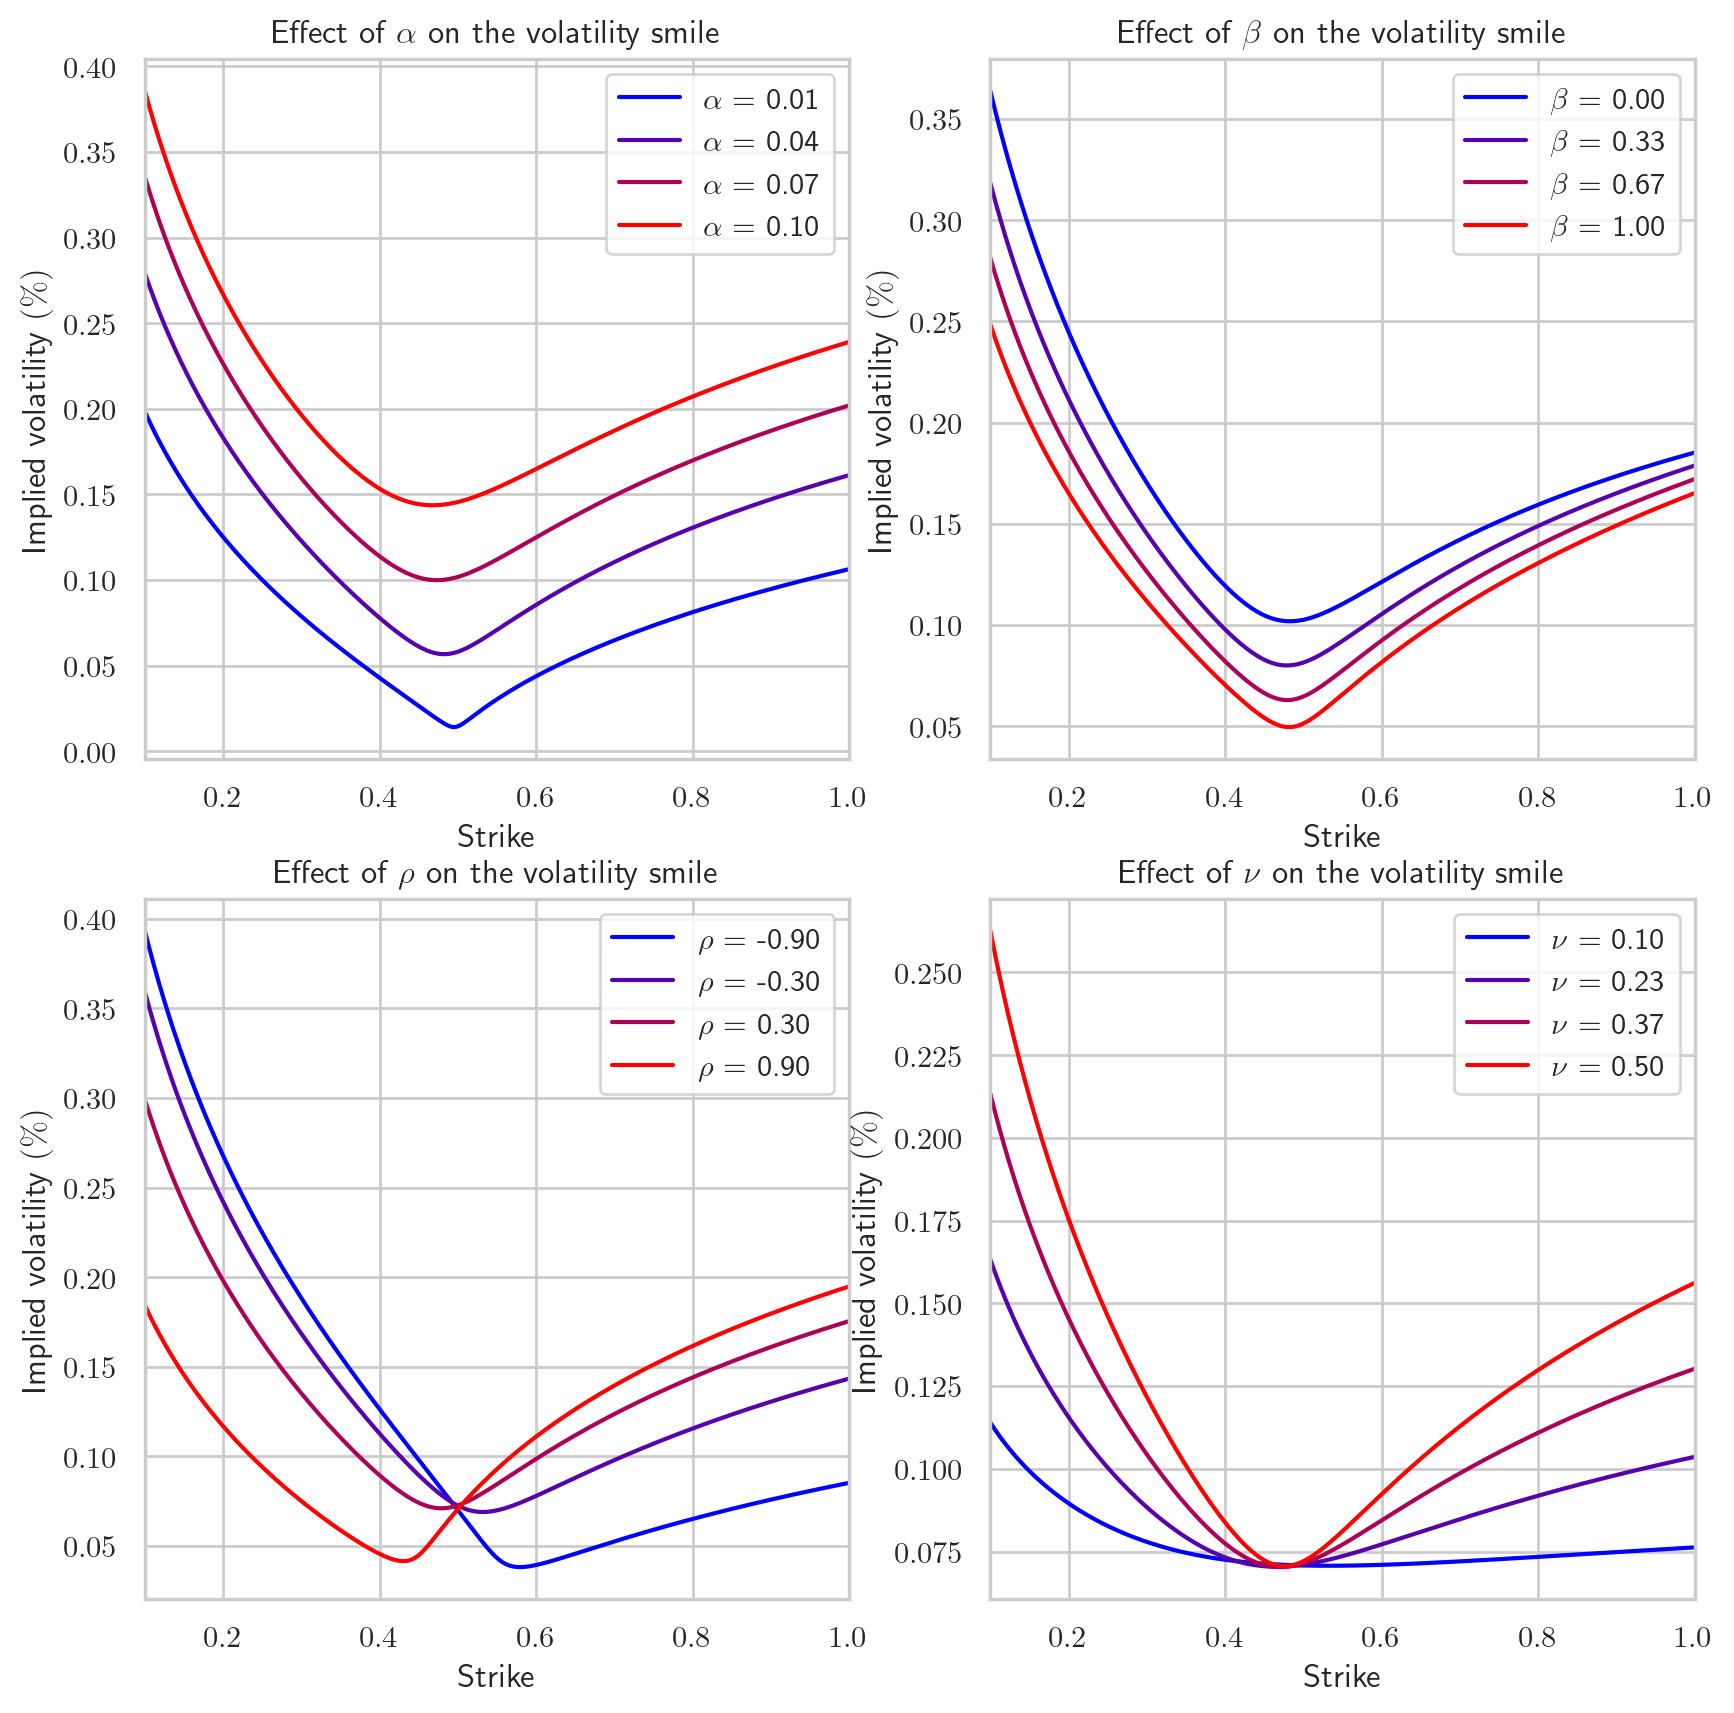

In [25]:
# Initialize variables
f = 0.5
K = np.linspace(0.1, 1, 1000)
t = 1
alpha = 0.01
beta = 0.5
rho = 0.3
nu = 0.6

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)

n = 4
alphas = np.linspace(0.01, 0.1, n)
betas = np.linspace(0, 1, n)
rhos = np.linspace(-0.9, 0.9, n)
nus = np.linspace(0.1, 0.5, n)

# Plot volatility smile for different values of alpha
for alpha in alphas:
    vol = SABROptionPricer(f, K, t, alpha, beta, rho, nu).implied_vol
    axs[0, 0].plot(K, vol, label=r"$\alpha$ = " + f'{alpha:.2f}')

# Set alpha back to its original value
alpha = 0.05

# Plot volatility smile for different values of beta
for beta in betas:
    vol = SABROptionPricer(f, K, t, alpha, beta, rho, nu).implied_vol
    axs[0, 1].plot(K, vol, label=r"$\beta$ = " + f'{beta:.2f}')

# Set beta back to its original value
beta = 0.5

# Plot volatility smile for different values of rho
for rho in rhos:
    vol = SABROptionPricer(f, K, t, alpha, beta, rho, nu).implied_vol
    axs[1, 0].plot(K, vol, label=r"$\rho$ = " + f'{rho:.2f}')

# Set rho back to its original value
rho=0.3

# Plot volatility smile for different values of nu
for nu in nus:
    vol = SABROptionPricer(f, K, t, alpha, beta, rho, nu).implied_vol
    axs[1, 1].plot(K, vol, label=r"$\nu$ = " + f'{nu:.2f}')

# Set titles and labels for the subplots
axs[0, 0].set_title(r'Effect of $\alpha$ on the volatility smile')
axs[0, 1].set_title(r'Effect of $\beta$ on the volatility smile')
axs[1, 0].set_title(r'Effect of $\rho$ on the volatility smile')
axs[1, 1].set_title(r'Effect of $\nu$ on the volatility smile')

for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel(r'Strike')
        axs[i, j].set_ylabel(r'Implied volatility $(\%)$')
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(0.1, 1)

# Save the figure to a file and display it
plt.savefig('SABR_params.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [26]:
def get_lim(arr):
    notnan = ~np.isnan(arr)
    return (arr[notnan].min(), arr[notnan].max())

def plot_greek(SABR, greek, ax):
    """
    Plots the Black-Scholes and SABR Greeks for a given SABR object.

    Parameters:
        SABR (SABR): SABR object containing relevant data.
        greek (str): Greek to plot.
        ax (matplotlib.axes.Axes): Matplotlib Axes object to plot the graph.

    Returns:
        None
    """
    sabr_greek = SABR.sabr_greek_dict[greek]
    bs_greek = SABR.bs_greek_dict[greek]
    sabr_min, sabr_max = get_lim(sabr_greek)
    bs_min, bs_max = get_lim(bs_greek)
    if sabr_min < bs_min:
        mn = sabr_min
    else:
        mn = bs_min
    mx = np.max([sabr_max, bs_max])
    ax.vlines(SABR.sabr_params['K'], ymin=mn-(0.7*abs(mn)), ymax=mx+abs(0.2*mx), colors='k', linestyle='--', label='Strike')
    ax.plot(SABR.sabr_params['f'], bs_greek, label='Black-Scholes', c='blue')
    ax.plot(SABR.sabr_params['f'], sabr_greek, label='SABR', c='red')
    ax.set_xlim(get_lim(SABR.sabr_params['f']))
    ax.set_ylim(mn-(0.6*abs(mn)), mx+abs(0.2*mx))
    ax.legend()

/var/folders/cn/6w6_5cbx5wq5y54qfcv60t7m0000gn/T/ipykernel_97871/4068768329.py:146: RuntimeWarning: invalid value encountered in true_divide
  implied_vol = (alpha / series1) * (z / x * series2)


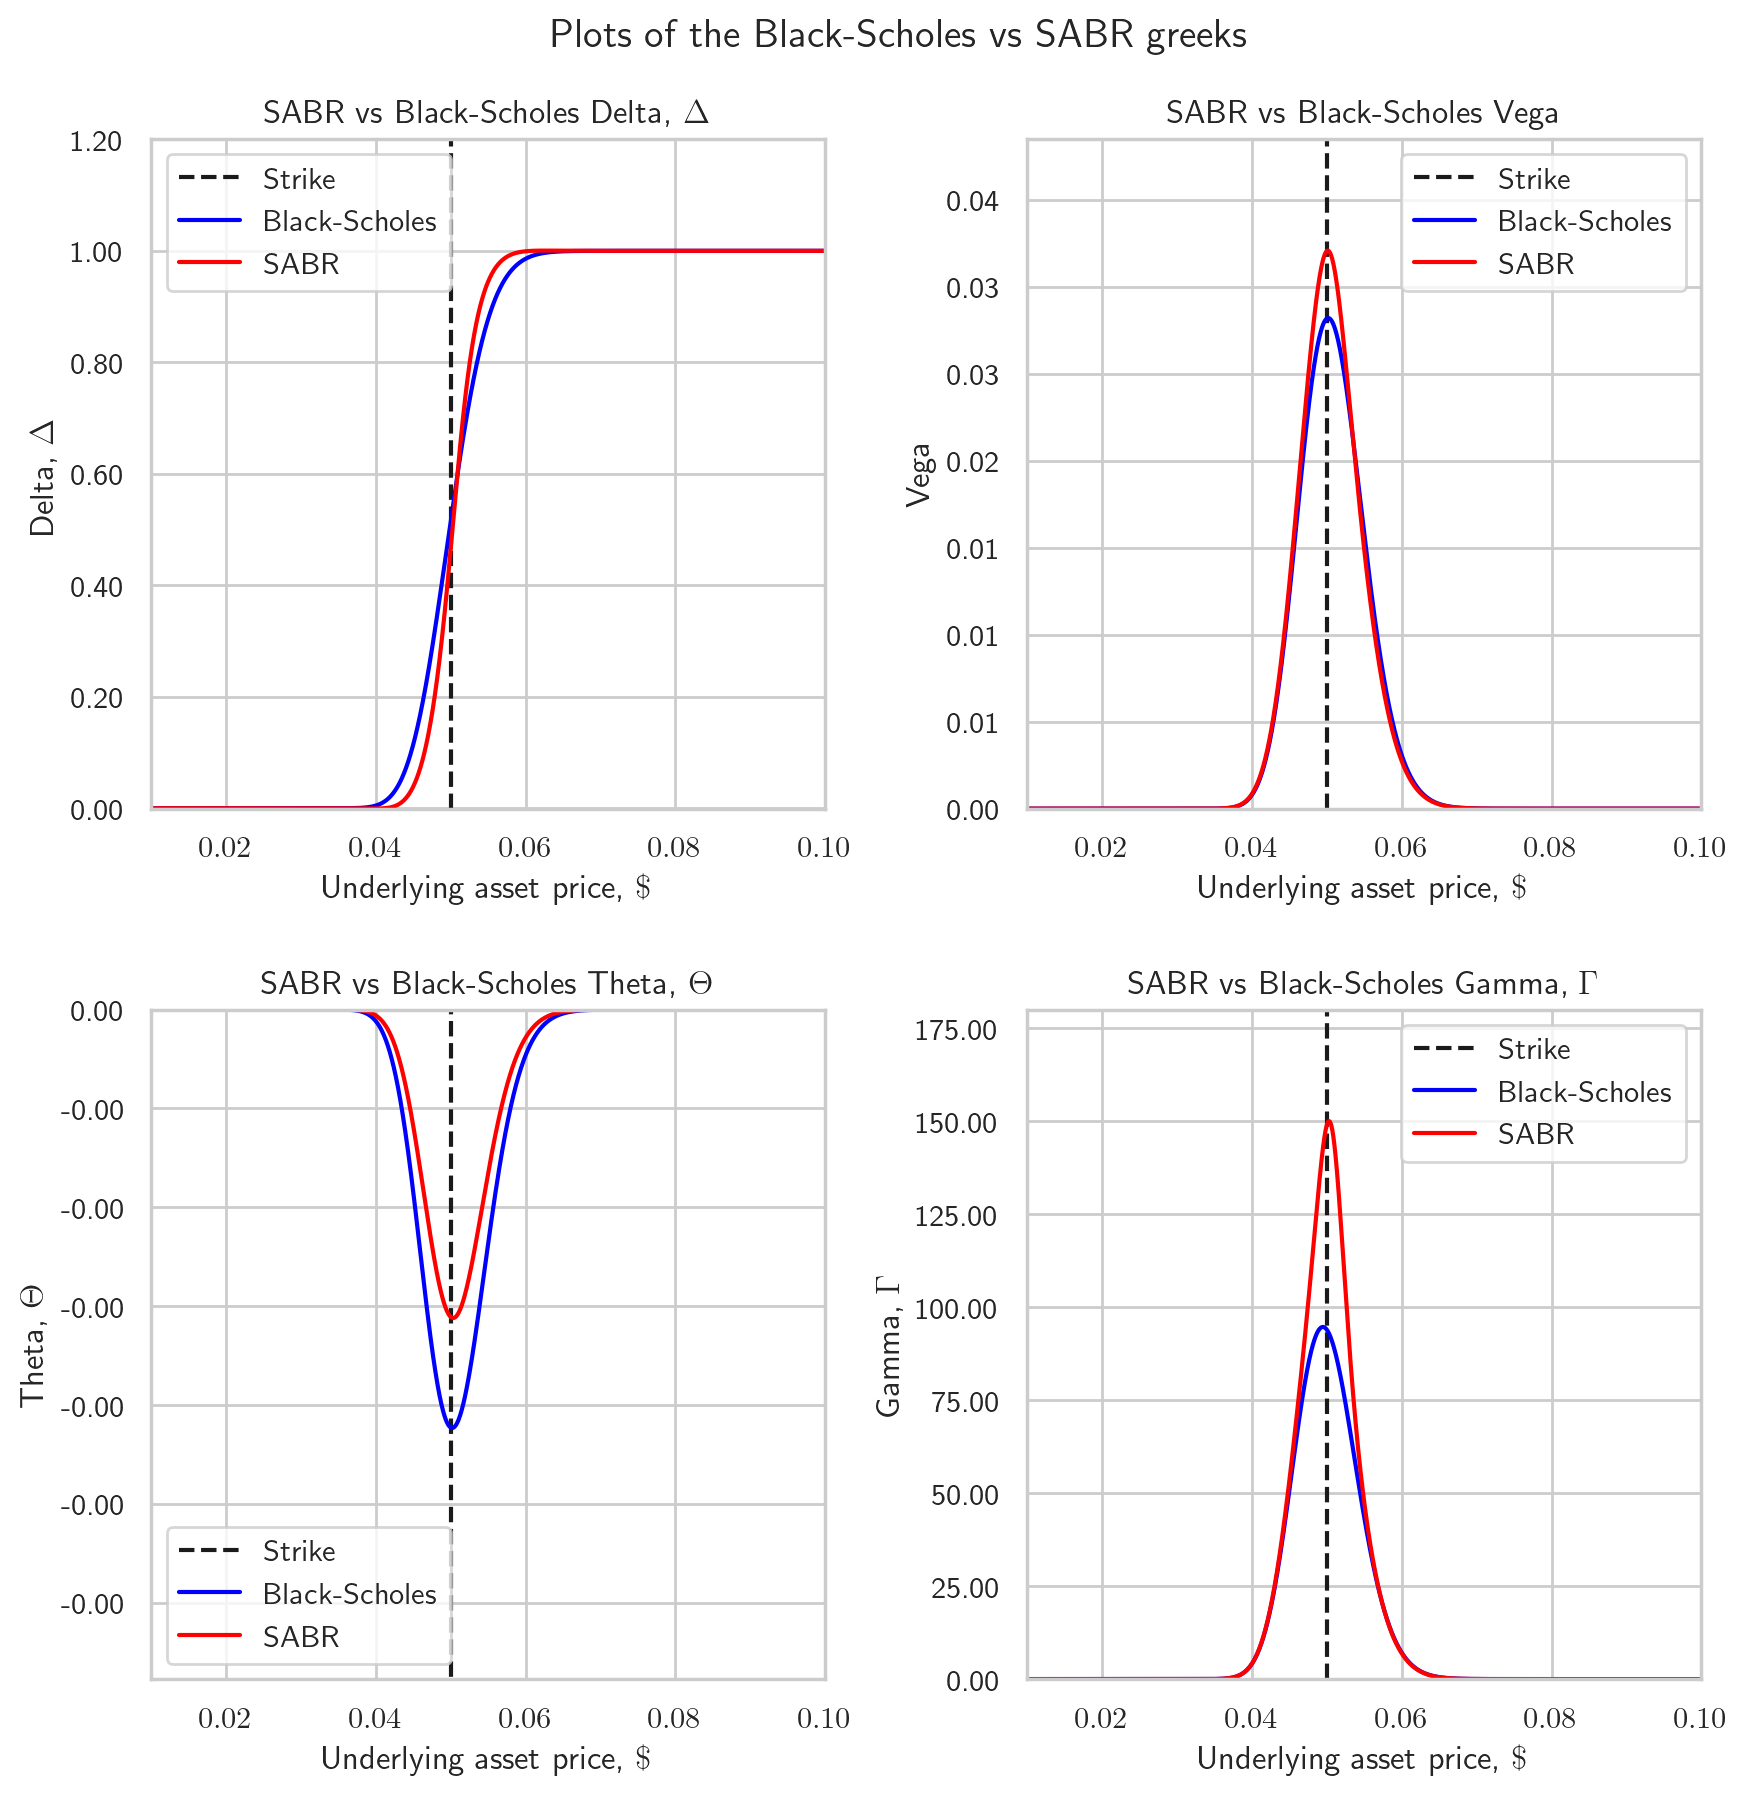

In [27]:
# Define the parameters for the SABR model
sabr_params = {
    'f':np.linspace(0.01, 0.1, 10000),
    'K':0.05,
    't':2.,
    'alpha':0.06,
    'beta':1,
    'rho':0.2,
    'nu':0.9
}  


# Instantiate the SABROptionPricer class with the parameters in the dictionary
SABR = SABROptionPricer(**sabr_params)

# Compute the Greeks using the BlackScholesPricer class methods
greeks = np.array([
    ['delta', 'vega'],  # Delta and Vega
    ['theta', 'gamma']  # Theta and Gamma
])

# Define the names for the Greeks for use in plot titles and y-axis labels
names = np.array([
    [r'Delta, $\Delta$', r'Vega'],  
    [r'Theta, $\Theta$', r'Gamma, $\Gamma$'] 
])

# Create a 2x2 subplot of the four Greeks
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Iterate over each subplot and plot the Greek values against the underlying asset price (S)
for i, j in itertools.product(range(2), range(2)):
    plot_greek(SABR, greeks[i,j], axs[i, j])  # Plot the Greek values against the underlying asset price (S) # Add a red dashed line for the strike price (K)
    axs[i, j].set_title('SABR vs Black-Scholes ' + names[i, j])  # Set the plot title
    axs[i, j].set_xlim(0.01, 0.1)  # Set the x-axis limits
    axs[i, j].set_xlabel('Underlying asset price, $\\$$')  # Set the x-axis label
    axs[i, j].set_ylabel(names[i, j])  # Set the y-axis label
    axs[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Set the y-axis format to two decimal places
    axs[i, j].legend()  # Add a legend to the plot

# Set the overall plot title and save the plot as a PNG file
plt.suptitle('Plots of the Black-Scholes vs SABR greeks', y=0.94)
plt.savefig('SABR_vs_Black_Scholes_greeks.png', dpi=DPI, bbox_inches='tight')

# Display the plot
plt.show()


### ZABR model


The code to calulate the implied volatility for the ZABR model was first written in MATLAB in https://uk.mathworks.com/matlabcentral/fileexchange/50328-zabr-stochastic-volatility-smile-modelling, which I translated to Python. 

In [28]:
def sigS(S):
    return alpha * S**beta  # Calculate the function sigS(S) = alpha * S^beta

def odefun(t, f, A, B, C):
    return 0.5 * (-B(t) * f + np.sqrt(abs(B(t)**2 * f**2 - 4 * A(t) * (C * f**2 - 1)))) / A(t)
    # Define the ordinary differential equation function for numerical integration

def zabr_implied_vol(S, K, T, alpha, beta, rho, volvol, gamma):
        
    '''
    Calculates the implied volatilities for the ZABR (ZaBeRo) model.

    The ZABR model is a stochastic volatility model used in quantitative finance to describe
    the dynamics of implied volatility in the options market. Given the input parameters and
    option market data, this function computes the implied volatilities using the ZABR model.

    Parameters:
    - S (float): Spot price or forward price of the underlying asset.
    - K (array-like): Strike prices of the options.
    - T (float): Time to expiration of the options in years.
    - alpha (float): Initial volatility level.
    - beta (float): Exponent determining the forward volatility skew.
    - rho (float): Correlation between the underlying asset and the volatility process.
    - volvol (float): Volatility of the volatility process.
    - gamma (float): Exponent determining the shift of the forward volatility skew.

    Returns:
    - impvol (array): Array of implied volatilities corresponding to the input strike prices.
    '''

    nubar = np.zeros_like(K)  # Create an array of zeros with the same shape as K
    nu = np.zeros_like(K)  # Create an array of zeros with the same shape as K
    impvol = np.zeros_like(K)  # Create an array of zeros with the same shape as K
    callMat = np.zeros_like(K)  # Create an array of zeros with the same shape as K
    callMat2 = callMat

    fy = np.zeros_like(K)  # Create an array of zeros with the same shape as K
    
    if abs(gamma - 1.0) > 1e-06:  # Check if the absolute difference between gamma and 1.0 is greater than 1e-06
        volvol = volvol * alpha**(1-gamma)  # Adjust volvol if the condition is true

    # Calculate analytical integral value
    y = ((S**(1-beta) - K**(1-beta)) / (1-beta)) * alpha**(gamma-2)

    A = lambda y: 1 + (gamma-2)**2 * (volvol**2) * y**2 + 2 * rho * (gamma-2) * volvol * y  # Define function A(y)
    B = lambda y: 2 * rho * (1-gamma) * volvol + 2 * (1-gamma) * (gamma-2) * (volvol**2) * y  # Define function B(y)
    C = (1-gamma)**2 * (volvol**2)  # Calculate C value
    f0 = 0  # Initialize f0 to 0
    y0 = 0  # Initialize y0 to 0
    for i in range(K.shape[0]):  # Iterate over the elements of K
        if np.isclose(K[i], S, 0.0001):  # Check if K[i] is close to S with a tolerance of 0.0001
            fy[i] = 0  # Set fy[i] to 0 if the condition is true
        else:
            tt, yy = odeint(odefun, f0, (y0, y[i]), args=(A,B,C), rtol=1e-10, atol=1e-12)
            fy[i] = yy[-1]  # Set fy[i] to the last value of yy
            f0 = fy[i]  # Update f0 to fy[i]
            y0 = y[i]  # Update y0 to y[i]
    x = alpha**(1 - gamma) * fy  # Calculate x value
    nu = (S - K) / x
    nu[np.isclose(K, S, 0.001)] = S**beta * alpha

    # Transfer the implied normal vols to implied black vols
    c1 = nu * np.sqrt(T)  # Calculate c1 value
    c2 = (S - K) / c1  # Calculate c2 value
    callBachelier = (S - K) * norm.cdf(c2) + c1 * norm.pdf(c2)  # Calculate call option prices using Bachelier formula
    impvol = implied_vol(callBachelier, S, K, T, 0, 'c', return_as='numpy')  # Calculate implied volatility using the Black formula
    return impvol  # Return the implied volatilities


/var/folders/cn/6w6_5cbx5wq5y54qfcv60t7m0000gn/T/ipykernel_97871/1393996250.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nu = (S - K) / x
/Users/ollie/miniconda3/lib/python3.9/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Above Maximum Price contracts at index [0, 1, 2]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
/Users/ollie/miniconda3/lib/python3.9/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Above Maximum Price contracts at index [0, 1, 2, 3, 4, 5, 6, 7]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
/Users/ollie/miniconda3/lib/python3.9/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Above Maximum Price contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2

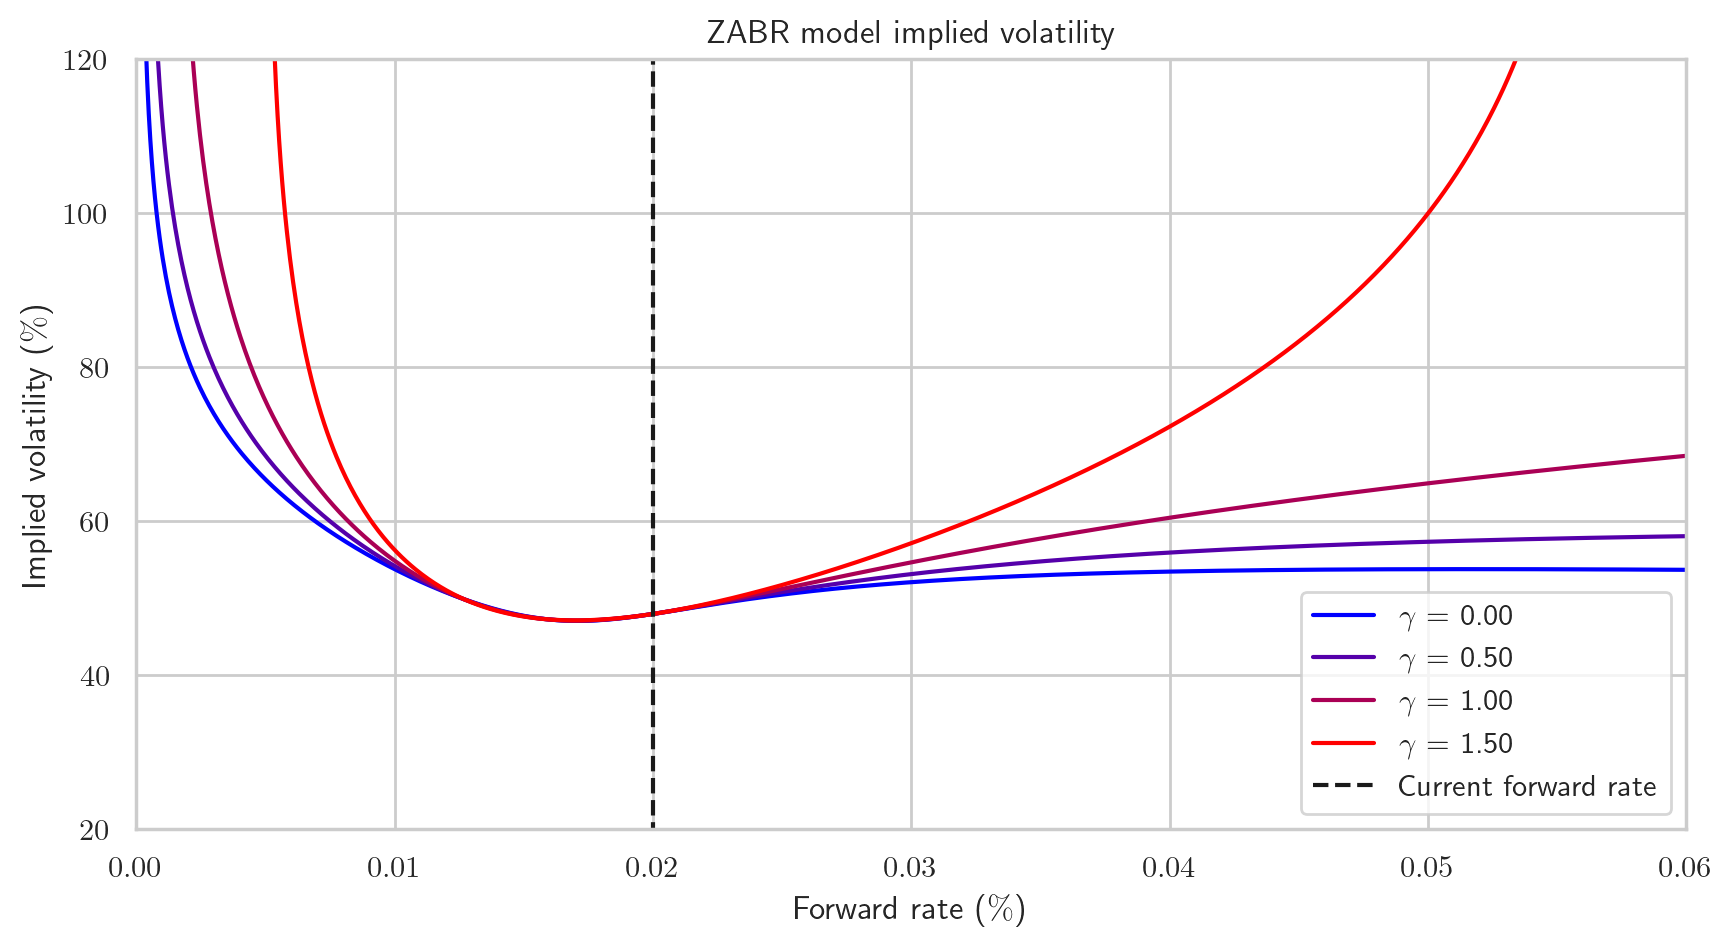

In [29]:
S = 0.02  # Initial value of S

T = 10  # Time to expiration
alpha = 0.2  # Alpha parameter
rho = 0.3  # Rho parameter

beta = 0.8  # Beta parameter
epsi = 0.8  # Epsilon parameter
K = np.linspace(1e-9, 0.06, 1000)  # Array of strike prices

# Create a new figure for the plot
plt.figure(figsize=(10, 5), dpi=200)

# Iterate over a range of gamma values and plot the implied volatilities
for gamma in np.linspace(0, 1.5, 4):
    vols = zabr_implied_vol(S, K, T, alpha, beta, rho, epsi, gamma)  # Calculate implied volatilities
    plt.plot(K, vols*100, label=f'$\\gamma$ = {gamma:.2f}')  # Plot the implied volatilities

# Add a vertical line representing the current forward rate
plt.vlines(S, 0, 120, label='Current forward rate', colors='k', linestyle='--')

plt.legend()  # Add a legend to the plot
plt.xlim(0, 0.06)  # Set the x-axis limits
plt.ylim(20, 120)  # Set the y-axis limits
plt.ylabel('Implied volatility ($\\%$)')  # Set the label for the y-axis
plt.xlabel('Forward rate ($\\%$)')  # Set the label for the x-axis
plt.title('ZABR model implied volatility')  # Set the title of the plot

plt.savefig('ZABR.png', dpi=DPI, bbox_inches='tight')  # Save the plot as an image file
plt.show()  # Display the plot
